In [160]:
import os
from pathlib import Path
import pandas as pd
from lifelines import CoxPHFitter
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
# import forestplot as fp
from tabulate import tabulate
from matplotlib.ticker import FormatStrFormatter

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.datasets import load_waltons
from contextlib import redirect_stdout

from collections import defaultdict

evaluation_generated_dir = Path("/Users/projects_data/project_MLPhenotypesMRIGWAS/evaluation_generated_data/23_03_30") / "survival_analysis_cluster"
organized_generated_dir = Path("/Users/projects_data/project_MLPhenotypesMRIGWAS/organized_data/23_03_30")
os.makedirs(evaluation_generated_dir, exist_ok=True)

data_all = pd.read_parquet(organized_generated_dir / 'combinedData.parquet.gzip')
data_all['id_invicrot1_vol_temporal_rdktlobes'] = 1 - data_all['id_invicrot1_vol_temporal_rdktlobes']
data_all['id_invicrot1_vol_gmtissues'] = 1 - data_all['id_invicrot1_vol_gmtissues']
data_all['id_invicrot1_vol_left_entorhinaldktcortex'] = 1 - data_all['id_invicrot1_vol_left_entorhinaldktcortex']

subject_max = data_all.set_index('eid')[['Age_i0', 'Age_i1', 'Age_i2', 'Age_i3']].agg(max, axis=1) # - data.set_index('eid')[['Age_i0', 'Age_i1', 'Age_i2', 'Age_i3']].agg(min, axis=1)
subject_max = subject_max.reset_index().groupby('eid').agg('max')[0]
study_time = dict(zip(list(subject_max.index), list(subject_max.values)))

subject_max = data_all.set_index('eid')[['Date_of_attending_assessment_centre_i0',
 'Date_of_attending_assessment_centre_i1',
 'Date_of_attending_assessment_centre_i2',
 'Date_of_attending_assessment_centre_i3']].agg(max, axis=1) # - data.set_index('eid')[['Age_i0', 'Age_i1', 'Age_i2', 'Age_i3']].agg(min, axis=1)
subject_max = subject_max.reset_index().groupby('eid').agg('max')[0]
study_time = dict(zip(list(subject_max.index), list(subject_max.values)))

data = data_all[data_all['ukbb_id_nih'].str.contains('20252_2_0')].copy().set_index('eid')


In [161]:
data['Age_at_image_taken'] = (data['Date_of_attending_assessment_centre'] - data['birthMonthYear']) / 365

In [162]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='norm_PD_imaging_score ~ Age_at_image_taken', missing='drop', data=data)
res = mod.fit()
print(res.summary())
data['adjusted_norm_PD_imaging_score'] = data['norm_PD_imaging_score'] - res.params.loc['Age_at_image_taken'] * data['Age_at_image_taken']

                              OLS Regression Results                             
Dep. Variable:     norm_PD_imaging_score   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.000
Method:                    Least Squares   F-statistic:                   0.01303
Date:                   Wed, 10 May 2023   Prob (F-statistic):              0.909
Time:                           12:04:41   Log-Likelihood:                -45645.
No. Observations:                  42695   AIC:                         9.129e+04
Df Residuals:                      42693   BIC:                         9.131e+04
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

In [163]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='norm_AD_imaging_score ~ Age_at_image_taken', missing='drop', data=data)
res = mod.fit()
print(res.summary())
data['adjusted_norm_AD_imaging_score'] = data['norm_AD_imaging_score'] - res.params.loc['Age_at_image_taken'] * data['Age_at_image_taken']

                              OLS Regression Results                             
Dep. Variable:     norm_AD_imaging_score   R-squared:                       0.060
Model:                               OLS   Adj. R-squared:                  0.060
Method:                    Least Squares   F-statistic:                     2712.
Date:                   Wed, 10 May 2023   Prob (F-statistic):               0.00
Time:                           12:04:41   Log-Likelihood:                -75162.
No. Observations:                  42695   AIC:                         1.503e+05
Df Residuals:                      42693   BIC:                         1.503e+05
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

In [217]:

disease = "PD"
formula = f"Age_at_image_taken + townsend + Sex + PD_prs + norm_PD_imaging_score"
variable_of_interest = "norm_PD_imaging_score"
censoring_time = 3650

list_disease = ['PD', 'ALL_DEMENTIA', 'PARKINSONISM', 'AD', "MS", "STROKE", "OtMOVEMENT", "DYSTONIA"]
list_disease = ['PD']
list_formula = [
    # f"Age_at_image_taken + townsend + Sex + AD_prs + var:id_invicrot1_vol_temporal_rdktlobes",
    # f"Age_at_image_taken + townsend + Sex + AD_prs + var:id_invicrot1_vol_gmtissues",
    # f"Age_at_image_taken + townsend + Sex + AD_prs + var:id_invicrot1_vol_left_entorhinaldktcortex",
    # f"Age_at_image_taken + townsend + Sex + AD_prs + PD_prs + var:norm_AD_imaging_score + var:norm_PD_imaging_score"
    f"Age_at_image_taken + townsend + Sex + PD_prs + var:norm_PD_imaging_score",
    # f"Age_at_image_taken + townsend + Sex + AD_prs + var:norm_AD_imaging_score",
]

MAP = {}
disease_formula = [
    ('PD', f"Age_at_image_taken + townsend + Sex + PD_prs + var:norm_PD_imaging_score"),
    ('ALL_DEMENTIA', f"Age_at_image_taken + townsend + Sex + AD_prs + var:norm_AD_imaging_score"),
    ('MCI', 'age_at_image_taken + sex + brainVolume + var:norm_AD_imaging_score')
]
# disease_formula = [
#    ('PD', f"townsend + Sex + PD_prs + var:adjusted_norm_PD_imaging_score"),
#    ('PD', f"townsend + Sex + var:PD_prs"),
#    ('ALL_DEMENTIA', f"townsend + Sex + AD_prs + var:adjusted_norm_AD_imaging_score"),
#    ('ALL_DEMENTIA', f"townsend + Sex + var:AD_prs"),
#
#    ('MCI', 'age_at_image_taken + sex + brainVolume + var:norm_AD_imaging_score')
# ]
for disease, temp_formula in disease_formula:
        list_variable_of_interest = [var.split(':')[1] for var in temp_formula.split(' + ') if 'var' in var]
        formula = temp_formula.replace('var:', '')
        if not disease == 'MCI':
            # variable_of_interest = formula.split(' + ')[-1]
            fname = f"{disease}&{formula.replace(' + ', '@')}"
            # os.makedirs(evaluation_generated_dir / fname, exist_ok=True)
            duration_col = f"daysFromDiagnosis_image_taken_{disease}"
            data[duration_col] = (data[f'Date_of_{disease}'] - data['Date_of_attending_assessment_centre']) / 365
            # data['Age_at_image_taken'] = data['Age.when.attended.assessment.centre_nih'].values
            
            data['Age_at_image_taken'] = (data['Date_of_attending_assessment_centre'] - data['birthMonthYear']) / 365
            # data['Age_at_image_taken'] = data['Age_at_image_taken'].map(lambda x: round(x))

            temp_input_data = data.copy()
            event_subjects = temp_input_data[temp_input_data[duration_col] > 0].index
            event_subjects_data = temp_input_data.loc[event_subjects].copy()
            event_subjects_data[f"Status_{duration_col}"] = 1
            event_subjects_data.loc[event_subjects_data[duration_col]>5, f"Status_{duration_col}"] = 0 
            event_subjects_data[duration_col] = event_subjects_data[duration_col].map(lambda x: min(x, 5))

            

            right_censored_subjects = temp_input_data[temp_input_data[duration_col].isnull()].index
            right_censored_subjects_data = temp_input_data.loc[right_censored_subjects].copy()
            
            right_censored_subjects_data[duration_col] = (right_censored_subjects_data.index.map(lambda x: study_time[x]) - right_censored_subjects_data['Date_of_attending_assessment_centre']) / 365
            # right_censored_subjects_data[duration_col] = (right_censored_subjects_data.index.map(lambda x: study_time[x]) - right_censored_subjects_data['Age_at_image_taken'])
            
            
            right_censored_subjects_data = right_censored_subjects_data[right_censored_subjects_data[duration_col] > 0].copy()
            right_censored_subjects_data[f"Status_{duration_col}"] = 0
            
            right_censored_subjects_data[duration_col] = right_censored_subjects_data[duration_col].map(lambda x: min(x, 5))

            input_data = pd.concat([event_subjects_data, right_censored_subjects_data], axis=0)

            input_data_columns = formula.split(' + ') + [ duration_col, f"Status_{duration_col}" ]
            input_data_survival = input_data[input_data_columns].copy().dropna(subset=formula.split(' + '))
            
            # input_data_survival = input_data_survival[input_data_survival[duration_col] <= 5]

            input_data_survival_class1 = input_data_survival[input_data_survival[f"Status_{duration_col}"] == 1].copy()
            input_data_survival_class0 = input_data_survival[input_data_survival[f"Status_{duration_col}"] == 0].sample(n=len(input_data_survival_class1)).copy()
            input_data_survival_balanced = pd.concat([input_data_survival_class0, input_data_survival_class1], axis=0)
        else:
            T = pd.read_csv("data/MCI_survival.csv")
            duration_col = f"daysFromDiagnosis_image_taken_{disease}"
            T['norm_AD_imaging_score'] = T['ens_logit_ad_severity_scores'].values
            T[f"daysFromDiagnosis_image_taken_{disease}"] = T['time_from_diagnosis'].values
            T[f"Status_{duration_col}"] = T['event_col'].values
            # T.loc[T[duration_col]>5, f"Status_{duration_col}"] = 0 
            input_data_survival = T.copy()
            input_data_survival.loc[input_data_survival[duration_col]>5, f"Status_{duration_col}"] = 0 
            input_data_survival[duration_col] = input_data_survival[duration_col].map(lambda x: min(x, 5))
            
            
        if True:
            cph_temp = CoxPHFitter()
            
            # checking with normaliz
            cph_temp.fit(input_data_survival, duration_col=duration_col, event_col=f"Status_{duration_col}", formula=formula)
            cph_temp.print_summary()
            
            #checking with normaliz
            input_data_survival_norm = input_data_survival.copy()
            means = input_data_survival_norm[list_variable_of_interest[0]].mean()
            stds = input_data_survival_norm[list_variable_of_interest[0]].std()

            input_data_survival_norm['scale' + list_variable_of_interest[0]] = (input_data_survival_norm[list_variable_of_interest[0]] - means) / stds
            cph_temp.fit(input_data_survival_norm, duration_col=duration_col, event_col=f"Status_{duration_col}", formula=formula.replace(list_variable_of_interest[0], 'scale' + list_variable_of_interest[0]))
            cph_temp.print_summary()
            
            # cph_temp.summary.to_csv(f"Figure3/Survival_analysis_{disease}.csv")
            # MAP[disease] = [cph, input_data_survival, covariate_columns]
            
            covariate_columns = []
            QCUT = {"ALL_DEMENTIA": 4, "MCI": 2, "PD": 4}
            for variable_of_interest in list_variable_of_interest:
                formula = formula.replace(variable_of_interest, "")
                v = pd.qcut(input_data_survival[variable_of_interest], QCUT[disease])
                input_data_survival[f"quantiles_{variable_of_interest}"] = v.cat.codes.map(lambda x: f'Q{x}')
                addition_columns = pd.get_dummies(input_data_survival[f"quantiles_{variable_of_interest}"])
                addition_columns.columns = [f"{variable_of_interest}_{j}" for j in addition_columns.columns]
                formula += ' + '.join(list(addition_columns.columns)[1:])
                input_data_survival = pd.concat([input_data_survival, addition_columns], axis=1)
                covariate_columns.extend(list(addition_columns.columns)[1:])

            cph = CoxPHFitter()
            cph.fit(input_data_survival, duration_col=duration_col, event_col=f"Status_{duration_col}", formula=formula)
            # cph.print_summary()
            MAP[disease] = [cph, input_data_survival, covariate_columns]
            
            # fig.savefig(evaluation_generated_dir / fname / "Survival_plot_Quantiles.png")
            # fig.savefig(evaluation_generated_dir / fname / "Survival_plot_Quantiles.pdf")

            # fig, ax = plt.subplots()
            # cph.plot(columns=sorted(covariate_columns)[::-1], hazard_ratios=True, ax=ax)
            # labels = [item.get_text().split('_')[-1] for item in ax.get_yticklabels()]
            # ax.set_yticklabels(labels)
            # fig.savefig(evaluation_generated_dir / fname / "Effect_size_Quantiles.png")
            # fig.savefig(evaluation_generated_dir / fname / "Effect_size_Quantiles.pdf")
        # break
        

<lifelines.CoxPHFitter: fitted with 4986 total observations, 4946 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4986
number of events observed = 40
   partial log-likelihood = -242.63
         time fit was run = 2023-05-10 20:42:10 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
Age_at_image_taken      0.19       1.21       0.03             0.14             0.24                 1.15                 1.28
PD_prs                  0.37       1.45       0.16             0.07             0.67                 1.07                 1.96
Sex                    -0.30       0.74       0.35            -0.98             0.39                 0.37                 1.48
norm_PD_imaging_score   1.22       3.38       0.30             0.63             1.80                 1.88                 6.07
townsend                0.02       1.02       0.06            -0.09             0.14                 0.91                 1.15

                        cmp to     z      p   -log2(p)
covariate                                             
Age_at_image_taken        0.00  7.41 <0.005      42.84
PD_prs                    0.00  2.39   0.02       5.87
Sex                       0.00 -0.84   0.40       1.32
norm_PD_imaging_score     0.00  4.06 <0.005      14.34
townsend                  0.00  0.39   0.70       0.52
---
Concordance = 0.88
Partial AIC = 495.26
log-likelihood ratio test = 102.28 on 5 df
-log2(p) of ll-ratio test = 65.63

<lifelines.CoxPHFitter: fitted with 4986 total observations, 4946 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_PD'
                event col = 'Status_daysFromDiagnosis_image_taken_PD'
      baseline estimation = breslow
   number of observations = 4986
number of events observed = 40
   partial log-likelihood = -242.63
         time fit was run = 2023-05-10 20:42:10 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
Age_at_image_taken           0.19       1.21       0.03             0.14             0.24                 1.15                 1.28
PD_prs                       0.37       1.45       0.16             0.07             0.67                 1.07                 1.96
Sex                         -0.30       0.74       0.35            -0.98             0.39                 0.37                 1.48
scalenorm_PD_imaging_score   0.85       2.33       0.21             0.44             1.25                 1.55                 3.50
townsend                     0.02       1.02       0.06            -0.09             0.14                 0.91                 1.15

                             cmp to     z      p   -log2(p)
covariate                                                  
Age_at_image_taken             0.00  7.41 <0.005      42.84
PD_prs                         0.00  2.39   0.02       5.87
Sex                            0.00 -0.84   0.40       1.32
scalenorm_PD_imaging_score     0.00  4.06 <0.005      14.34
townsend                       0.00  0.39   0.70       0.52
---
Concordance = 0.88
Partial AIC = 495.26
log-likelihood ratio test = 102.28 on 5 df
-log2(p) of ll-ratio test = 65.63

<lifelines.CoxPHFitter: fitted with 5018 total observations, 4952 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5018
number of events observed = 66
   partial log-likelihood = -376.58
         time fit was run = 2023-05-10 20:42:10 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
AD_prs                  0.13       1.13       0.12            -0.11             0.37                 0.89                 1.44
Age_at_image_taken      0.15       1.17       0.02             0.11             0.20                 1.12                 1.22
Sex                    -0.42       0.66       0.28            -0.96             0.12                 0.38                 1.12
norm_AD_imaging_score   0.39       1.48       0.06             0.28             0.50                 1.33                 1.65
townsend                0.08       1.08       0.05            -0.02             0.17                 0.98                 1.18

                        cmp to     z      p   -log2(p)
covariate                                             
AD_prs                    0.00  1.02   0.31       1.71
Age_at_image_taken        0.00  7.27 <0.005      41.30
Sex                       0.00 -1.53   0.13       3.00
norm_AD_imaging_score     0.00  7.07 <0.005      39.22
townsend                  0.00  1.62   0.11       3.25
---
Concordance = 0.87
Partial AIC = 763.17
log-likelihood ratio test = 199.86 on 5 df
-log2(p) of ll-ratio test = 134.60

<lifelines.CoxPHFitter: fitted with 5018 total observations, 4952 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_ALL_DEMENTIA'
                event col = 'Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'
      baseline estimation = breslow
   number of observations = 5018
number of events observed = 66
   partial log-likelihood = -376.58
         time fit was run = 2023-05-10 20:42:10 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
AD_prs                       0.13       1.13       0.12            -0.11             0.37                 0.89                 1.44
Age_at_image_taken           0.15       1.17       0.02             0.11             0.20                 1.12                 1.22
Sex                         -0.42       0.66       0.28            -0.96             0.12                 0.38                 1.12
scalenorm_AD_imaging_score   0.56       1.76       0.08             0.41             0.72                 1.50                 2.05
townsend                     0.08       1.08       0.05            -0.02             0.17                 0.98                 1.18

                             cmp to     z      p   -log2(p)
covariate                                                  
AD_prs                         0.00  1.02   0.31       1.71
Age_at_image_taken             0.00  7.27 <0.005      41.30
Sex                            0.00 -1.53   0.13       3.00
scalenorm_AD_imaging_score     0.00  7.07 <0.005      39.22
townsend                       0.00  1.62   0.11       3.25
---
Concordance = 0.87
Partial AIC = 763.17
log-likelihood ratio test = 199.86 on 5 df
-log2(p) of ll-ratio test = 134.60

<lifelines.CoxPHFitter: fitted with 749 total observations, 708 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_MCI'
                event col = 'Status_daysFromDiagnosis_image_taken_MCI'
      baseline estimation = breslow
   number of observations = 749
number of events observed = 41
   partial log-likelihood = -213.42
         time fit was run = 2023-05-10 20:42:10 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age_at_image_taken     -0.04       0.96       0.02            -0.09             0.00                 0.92                 1.00
brainVolume            -1.13       0.32       3.02            -7.04             4.78                 0.00               118.80
norm_AD_imaging_score   0.41       1.50       0.05             0.31             0.50                 1.37                 1.65
sex                     0.06       1.06       0.40            -0.73             0.84                 0.48                 2.33

                        cmp to     z      p   -log2(p)
covariate                                             
age_at_image_taken        0.00 -1.81   0.07       3.83
brainVolume               0.00 -0.38   0.71       0.50
norm_AD_imaging_score     0.00  8.37 <0.005      53.95
sex                       0.00  0.15   0.88       0.18
---
Concordance = 0.86
Partial AIC = 434.84
log-likelihood ratio test = 67.54 on 4 df
-log2(p) of ll-ratio test = 43.60

<lifelines.CoxPHFitter: fitted with 749 total observations, 708 right-censored observations>
             duration col = 'daysFromDiagnosis_image_taken_MCI'
                event col = 'Status_daysFromDiagnosis_image_taken_MCI'
      baseline estimation = breslow
   number of observations = 749
number of events observed = 41
   partial log-likelihood = -213.42
         time fit was run = 2023-05-10 20:42:10 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
age_at_image_taken          -0.04       0.96       0.02            -0.09             0.00                 0.92                 1.00
brainVolume                 -1.13       0.32       3.02            -7.04             4.78                 0.00               118.80
scalenorm_AD_imaging_score   1.10       2.99       0.13             0.84             1.35                 2.31                 3.86
sex                          0.06       1.06       0.40            -0.73             0.84                 0.48                 2.33

                             cmp to     z      p   -log2(p)
covariate                                                  
age_at_image_taken             0.00 -1.81   0.07       3.83
brainVolume                    0.00 -0.38   0.71       0.50
scalenorm_AD_imaging_score     0.00  8.37 <0.005      53.95
sex                            0.00  0.15   0.88       0.18
---
Concordance = 0.86
Partial AIC = 434.84
log-likelihood ratio test = 67.54 on 4 df
-log2(p) of ll-ratio test = 43.60

In [1]:
import numpy as np

In [5]:
2 ** (-14.34), 2 ** (-53.95), 2 ** (-39.22)

(4.822029491353621e-05, 5.74687477517752e-17, 1.5617214311309988e-12)

In [222]:
# T['daysFromDiagnosis_image_taken_MCI']

<Figure size 640x480 with 0 Axes>

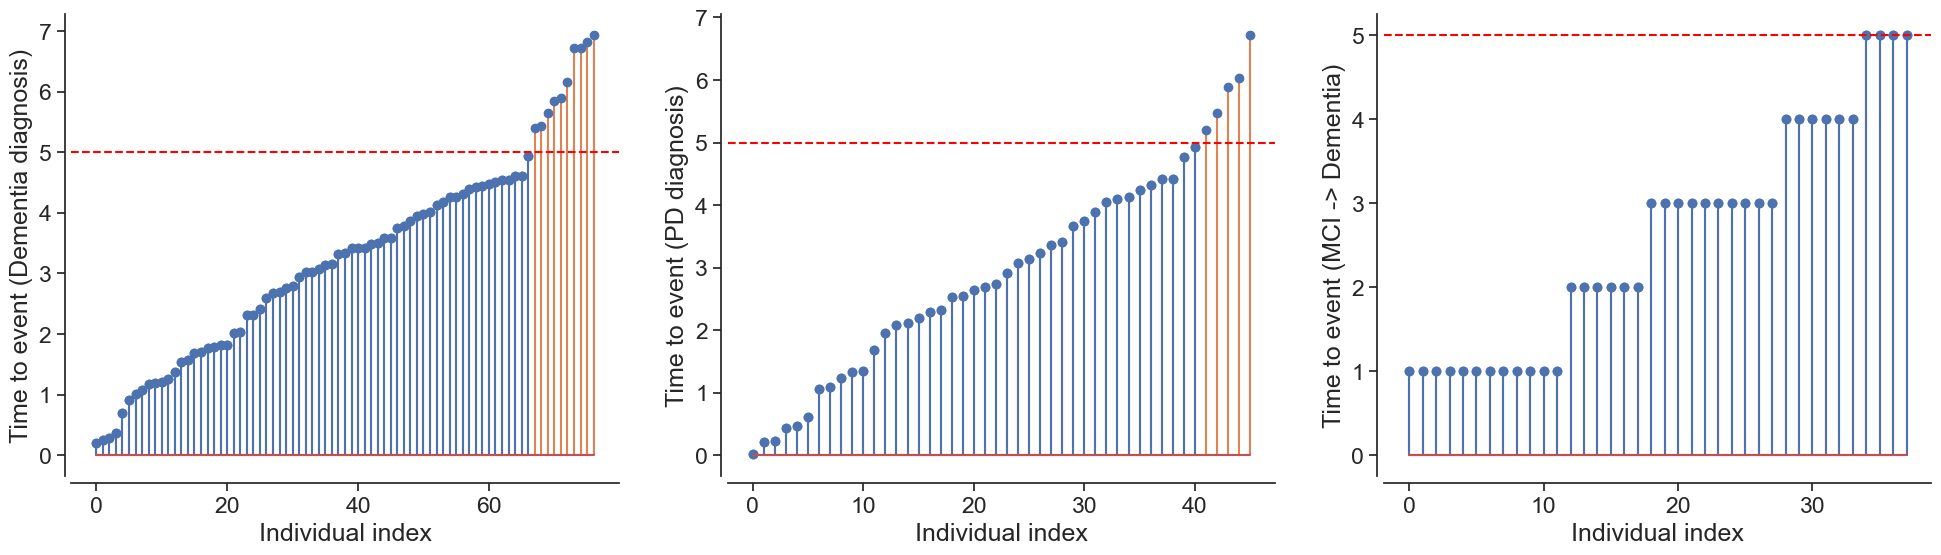

In [239]:
# Create a dataframe
import seaborn as sns
import pandas as pd
sns.reset_defaults()
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_theme("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("white", )
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.despine()

fig, (ax, ax2, ax3) = plt.subplots(ncols=3, figsize=(24, 6))
df = temp_input_data[temp_input_data["daysFromDiagnosis_image_taken_ALL_DEMENTIA"] > 0]
ordered_df = df.sort_values(by='daysFromDiagnosis_image_taken_ALL_DEMENTIA')
my_range=range(1,len(df.index)+1)
ordered_df['group'] = range(1,len(df.index)+1)
_ = ax.stem(ordered_df['daysFromDiagnosis_image_taken_ALL_DEMENTIA'], linefmt='C1-')
_ = ax.stem(ordered_df[ordered_df['daysFromDiagnosis_image_taken_ALL_DEMENTIA']<=5]['daysFromDiagnosis_image_taken_ALL_DEMENTIA'], linefmt='C0-')
ax.axhline(y=5, color='red', linestyle='--')
ax.set_xlabel('Individual index')
ax.set_ylabel('Time to event (Dementia diagnosis)')

df = temp_input_data[temp_input_data["daysFromDiagnosis_image_taken_PD"] > 0]
ordered_df = df.sort_values(by='daysFromDiagnosis_image_taken_PD')
my_range=range(1,len(df.index)+1)
ordered_df['group'] = range(1,len(df.index)+1)
_ = ax2.stem(ordered_df['daysFromDiagnosis_image_taken_PD'], linefmt='C1-')
_ = ax2.stem(ordered_df[ordered_df['daysFromDiagnosis_image_taken_PD']<=5]['daysFromDiagnosis_image_taken_PD'], linefmt='C0-')

ax2.axhline(y=5, color='red', linestyle='--')
ax2.set_xlabel('Individual index')
ax2.set_ylabel('Time to event (PD diagnosis)')


df = T[(T["daysFromDiagnosis_image_taken_MCI"] > 0) & (T['Status_daysFromDiagnosis_image_taken_MCI']==1)]
ordered_df = df.sort_values(by='daysFromDiagnosis_image_taken_MCI')
my_range=range(1,len(df.index)+1)
ordered_df['group'] = range(1,len(df.index)+1)
_ = ax3.stem(ordered_df['daysFromDiagnosis_image_taken_MCI'], linefmt='C1-')
_ = ax3.stem(ordered_df[ordered_df['daysFromDiagnosis_image_taken_MCI']<=5]['daysFromDiagnosis_image_taken_MCI'], linefmt='C0-')
ax3.axhline(y=5, color='red', linestyle='--')
ax3.set_xlabel('Individual index')
ax3.set_ylabel('Time to event (MCI -> Dementia)')

sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=5, trim=False)
fig.savefig("Step3_survival_analysis/SurvivalEventDuration.pdf", bbox_inches="tight")
fig.savefig("Step3_survival_analysis/SurvivalEventDuration.svg", bbox_inches="tight")
fig.savefig('Step3_survival_analysis/SurvivalEventDuration.png', dpi=200, bbox_inches = "tight")
# _ = plt.xticks( my_range, ordered_df['group'])

eid
4194314   NaN
4194337   NaN
3145785   NaN
2097232   NaN
3145830   NaN
           ..
4194213   NaN
4194228   NaN
1048549   NaN
3145706   NaN
4194297   NaN
Length: 42786, dtype: float64

<Figure size 640x480 with 0 Axes>

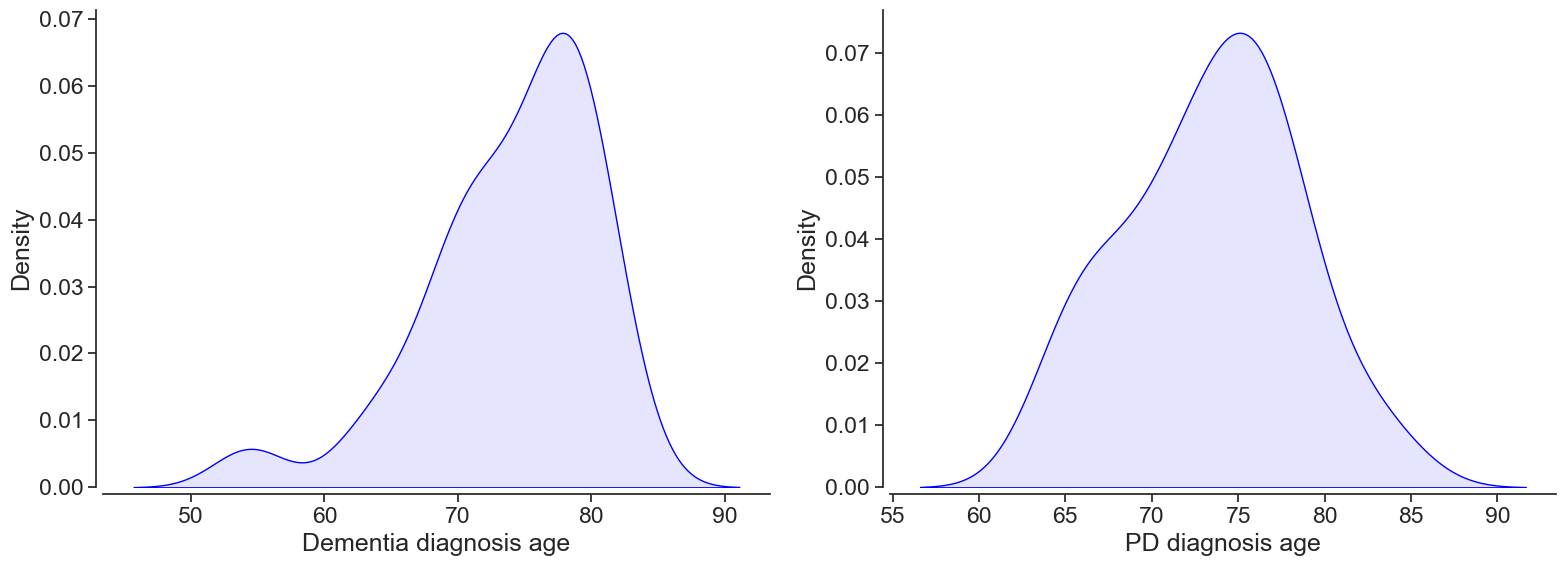

In [262]:
# Create a dataframe
import seaborn as sns
import pandas as pd
sns.reset_defaults()
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_theme("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("white", )
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.despine()

fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
df = temp_input_data[temp_input_data["daysFromDiagnosis_image_taken_ALL_DEMENTIA"] > 0]
df['Age_at_diagnosis'] = df['Age_at_image_taken'] + df["daysFromDiagnosis_image_taken_ALL_DEMENTIA"]
ordered_df = df.sort_values(by='Age_at_diagnosis')
my_range=range(1,len(df.index)+1)
ordered_df['group'] = range(1,len(df.index)+1)
sns.kdeplot(data=ordered_df, x='Age_at_diagnosis',color='blue', fill='blue', ax=ax, alpha=0.1, linewidth=1)
# _ = ax.stem(ordered_df['Age_at_diagnosis'], linefmt='C1-')
# _ = ax.stem(ordered_df[ordered_df['daysFromDiagnosis_image_taken_ALL_DEMENTIA']<=5]['daysFromDiagnosis_image_taken_ALL_DEMENTIA'], linefmt='C0-')
# ax.set_xlabel('Individual index')
ax.set_xlabel('Dementia diagnosis age')


df = temp_input_data[temp_input_data["daysFromDiagnosis_image_taken_PD"] > 0]
df['Age_at_diagnosis'] = df['Age_at_image_taken'] + df["daysFromDiagnosis_image_taken_PD"]
ordered_df = df.sort_values(by='Age_at_diagnosis')
my_range=range(1,len(df.index)+1)
ordered_df['group'] = range(1,len(df.index)+1)
sns.kdeplot(data=ordered_df, x='Age_at_diagnosis',color='blue', fill='blue', ax=ax2, alpha=0.1, linewidth=1)
# _ = ax2.stem(ordered_df['Age_at_diagnosis'], linefmt='C1-')
# _ = ax.stem(ordered_df[ordered_df['daysFromDiagnosis_image_taken_ALL_DEMENTIA']<=5]['daysFromDiagnosis_image_taken_ALL_DEMENTIA'], linefmt='C0-')
# ax2.set_xlabel('Individual index')
ax2.set_xlabel('PD diagnosis age')


"""
df = temp_input_data[temp_input_data["daysFromDiagnosis_image_taken_PD"] > 0]
ordered_df = df.sort_values(by='daysFromDiagnosis_image_taken_PD')
my_range=range(1,len(df.index)+1)
ordered_df['group'] = range(1,len(df.index)+1)
_ = ax2.stem(ordered_df['daysFromDiagnosis_image_taken_PD'], linefmt='C1-')
_ = ax2.stem(ordered_df[ordered_df['daysFromDiagnosis_image_taken_PD']<=5]['daysFromDiagnosis_image_taken_PD'], linefmt='C0-')

ax2.axhline(y=5, color='red', linestyle='--')
ax2.set_xlabel('Individual index')
ax2.set_ylabel('Time to event (PD diagnosis)')


df = T[(T["daysFromDiagnosis_image_taken_MCI"] > 0) & (T['Status_daysFromDiagnosis_image_taken_MCI']==1)]
ordered_df = df.sort_values(by='daysFromDiagnosis_image_taken_MCI')
my_range=range(1,len(df.index)+1)
ordered_df['group'] = range(1,len(df.index)+1)
_ = ax3.stem(ordered_df['daysFromDiagnosis_image_taken_MCI'], linefmt='C1-')
_ = ax3.stem(ordered_df[ordered_df['daysFromDiagnosis_image_taken_MCI']<=5]['daysFromDiagnosis_image_taken_MCI'], linefmt='C0-')
ax3.axhline(y=5, color='red', linestyle='--')
ax3.set_xlabel('Individual index')
ax3.set_ylabel('Time to event (MCI -> Dementia)')

sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=5, trim=False)
fig.savefig("Step3_survival_analysis/AgeAtDiagnosis.pdf", bbox_inches="tight")
fig.savefig("Step3_survival_analysis/AgeAtDiagnosis.svg", bbox_inches="tight")
fig.savefig('Step3_survival_analysis/AgeAtDiagnosis.png', dpi=200, bbox_inches = "tight")
# _ = plt.xticks( my_range, ordered_df['group'])
"""

sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=5, trim=False)
plt.tight_layout()
fig.savefig("Step3_survival_analysis/AgeAtDiagnosis.svg", bbox_inches="tight")
fig.savefig('Step3_survival_analysis/AgeAtDiagnosis.png', dpi=200, bbox_inches = "tight")

In [240]:
from collections import defaultdict
surv_dataframe = defaultdict(list)
cph = MAP['PD'][0]
input_data_survival = MAP['PD'][1]
for e in range(0, QCUT['PD']):
    surv_dataframe['var'].append(f"norm_PD_imaging_score_Q{e}")
    surv_dataframe['label'].append(f"Q{e+1}")
    if e == 0:
        surv_dataframe['r'].append(1)
        surv_dataframe['ll'].append(1)
        surv_dataframe['hl'].append(1)
        surv_dataframe['pval'].append(np.nan)
    else:
        surv_dataframe['r'].append(cph.summary.loc[f"norm_PD_imaging_score_Q{e}"]['exp(coef)'])
        surv_dataframe['ll'].append(cph.summary.loc[f"norm_PD_imaging_score_Q{e}"]['exp(coef) lower 95%'])
        surv_dataframe['hl'].append(cph.summary.loc[f"norm_PD_imaging_score_Q{e}"]['exp(coef) upper 95%'])
        surv_dataframe['pval'].append(cph.summary.loc[f"norm_PD_imaging_score_Q{e}"]['p'])
    x = input_data_survival[input_data_survival['quantiles_norm_PD_imaging_score']==f'Q{e}']['Status_daysFromDiagnosis_image_taken_PD'].value_counts()
    surv_dataframe["diagnosis_par"].append(f"{x.loc[1] if 1 in x.index else 0}/{sum(x)} ({round((x.loc[1]*100 if 1 in x.index else 0)/sum(x), 1)}%)")
    surv_dataframe['Quantile'].append(f"{e+1}")
    surv_dataframe['group'].append(f"Control -> PD (UKBB)")
    
cph = MAP['ALL_DEMENTIA'][0]
input_data_survival = MAP['ALL_DEMENTIA'][1]
for e in range(0, QCUT['ALL_DEMENTIA']):
    surv_dataframe['var'].append(f"norm_AD_imaging_score_Q{e}")
    surv_dataframe['label'].append(f"Q{e+1}")
    if e == 0:
        surv_dataframe['r'].append(1)
        surv_dataframe['ll'].append(1)
        surv_dataframe['hl'].append(1)
        surv_dataframe['pval'].append(np.nan)
    else:
        surv_dataframe['r'].append(cph.summary.loc[f"norm_AD_imaging_score_Q{e}"]['exp(coef)'])
        surv_dataframe['ll'].append(cph.summary.loc[f"norm_AD_imaging_score_Q{e}"]['exp(coef) lower 95%'])
        surv_dataframe['hl'].append(cph.summary.loc[f"norm_AD_imaging_score_Q{e}"]['exp(coef) upper 95%'])
        surv_dataframe['pval'].append(cph.summary.loc[f"norm_AD_imaging_score_Q{e}"]['p'])
        
    x = input_data_survival[input_data_survival['quantiles_norm_AD_imaging_score']==f'Q{e}']['Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'].value_counts()
    surv_dataframe["diagnosis_par"].append(f"{x.loc[1] if 1 in x.index else 0}/{sum(x)} ({round((x.loc[1]*100 if 1 in x.index else 0)/sum(x), 1)}%)")
    surv_dataframe['Quantile'].append(f"{e+1}")
    surv_dataframe['group'].append(f"Control -> Dementia (UKBB)")    
    
cph = MAP['MCI'][0]
input_data_survival = MAP['MCI'][1]
for e in range(0, QCUT['MCI']):
    surv_dataframe['var'].append(f"norm_AD_imaging_score_Q{e}")
    surv_dataframe['label'].append(f"Q{e+1}")
    if e == 0:
        surv_dataframe['r'].append(1)
        surv_dataframe['ll'].append(1)
        surv_dataframe['hl'].append(1)
        surv_dataframe['pval'].append(np.nan)
    else:
        surv_dataframe['r'].append(cph.summary.loc[f"norm_AD_imaging_score_Q{e}"]['exp(coef)'])
        surv_dataframe['ll'].append(cph.summary.loc[f"norm_AD_imaging_score_Q{e}"]['exp(coef) lower 95%'])
        surv_dataframe['hl'].append(cph.summary.loc[f"norm_AD_imaging_score_Q{e}"]['exp(coef) upper 95%'])
        surv_dataframe['pval'].append(cph.summary.loc[f"norm_AD_imaging_score_Q{e}"]['p'])
        
    x = input_data_survival[input_data_survival['quantiles_norm_AD_imaging_score']==f'Q{e}']['Status_daysFromDiagnosis_image_taken_MCI'].value_counts()
    surv_dataframe["diagnosis_par"].append(f"{x.loc[1] if 1 in x.index else 0}/{sum(x)} ({round((x.loc[1]*100 if 1 in x.index else 0)/sum(x), 1)}%)")
    print (x)
    surv_dataframe['Quantile'].append(f"{e+1}")
    surv_dataframe['group'].append(f"MCI -> Dementia (ADNI)")    
    
surv_dataframe = pd.DataFrame(surv_dataframe)
surv_dataframe['man_est_ci'] = surv_dataframe['r'].map(lambda x: str(round(x, 1))) + ' (' + surv_dataframe['ll'].map(lambda x: str(round(x, 1))) + '-' + surv_dataframe['hl'].map(lambda x: str(round(x, 1))) + ')'


0    373
1      2
Name: Status_daysFromDiagnosis_image_taken_MCI, dtype: int64
0    335
1     39
Name: Status_daysFromDiagnosis_image_taken_MCI, dtype: int64


In [241]:
surv_dataframe

,var,label,r,ll,hl,pval,diagnosis_par,Quantile,group,man_est_ci
0,norm_PD_imaging_score_Q0,Q1,1.000000,1.000000,1.000000,NaN,2/1247 (0.2%),1,Control -> PD (UKBB),1.0 (1.0-1.0)
1,norm_PD_imaging_score_Q1,Q2,2.459230,0.476040,12.704424,0.282808,5/1246 (0.4%),2,Control -> PD (UKBB),2.5 (0.5-12.7)
2,norm_PD_imaging_score_Q2,Q3,6.831938,1.529096,30.524809,0.011869,13/1246 (1.0%),3,Control -> PD (UKBB),6.8 (1.5-30.5)
3,norm_PD_imaging_score_Q3,Q4,8.533917,1.944192,37.459132,0.004499,20/1247 (1.6%),4,Control -> PD (UKBB),8.5 (1.9-37.5)
4,norm_AD_imaging_score_Q0,Q1,1.000000,1.000000,1.000000,NaN,5/1255 (0.4%),1,Control -> Dementia (UKBB),1.0 (1.0-1.0)
5,norm_AD_imaging_score_Q1,Q2,0.928162,0.293468,2.935530,0.899023,7/1254 (0.6%),2,Control -> Dementia (UKBB),0.9 (0.3-2.9)
6,norm_AD_imaging_score_Q2,Q3,0.758441,0.237977,2.417180,0.640120,7/1254 (0.6%),3,Control -> Dementia (UKBB),0.8 (0.2-2.4)
7,norm_AD_imaging_score_Q3,Q4,3.800236,1.468875,9.831875,0.005910,47/1255 (3.7%),4,Control -> Dementia (UKBB),3.8 (1.5-9.8)
8,norm_AD_imaging_score_Q0,Q1,1.000000,1.000000,1.000000,NaN,2/375 (0.5%),1,MCI -> Dementia (ADNI),1.0 (1.0-1.0)
9,norm_AD_imaging_score_Q1,Q2,32.134800,7.634812,135.254852,0.000002,39/374 (10.4%),2,MCI -> Dementia (ADNI),32.1 (7.6-135.3)


In [242]:
import anndata as ad

# calculate the Pearson's correlation between two variables
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
# seed random number generator

# calculate Pearson's correlation
# print('Pearsons correlation: %.3f' % corr)

adata = ad.read("/Users/projects_data/project_MLPhenotypesMRIGWAS/ml_generated_data/23_03_30/preprocessed_data/minmax_adata.h5ad")
from pathlib import Path
ml_generated_dir =  Path("/Users/EssentialCodeBase/project_MLPhenotypesMRIGWAS/block1_BaselineClassification/training/23_03_30/results_data")

ad_imaging_path = ml_generated_dir / "predictiveAnalysis/classification_detailed_metrics/phenotype_data/replication_ensemble_ad_imaging_probability_scores.csv"
pd_imaging_path = ml_generated_dir / "predictiveAnalysis/classification_detailed_metrics/phenotype_data/replication_ensemble_pd_imaging_probability_scores.csv"
ad2_imaging_data = pd.read_csv(ml_generated_dir / "predictiveAnalysis/classification_detailed_metrics/phenotype_data/ensemble_ad_imaging_probability_scores.csv")
pd2_imaging_data = pd.read_csv(ml_generated_dir / "predictiveAnalysis/classification_detailed_metrics/phenotype_data/ensemble_pd_imaging_probability_scores.csv")

ad_imaging_data = pd.read_csv(ad_imaging_path)
pd_imaging_data = pd.read_csv(pd_imaging_path)
ad_score_dictionary = dict(zip(list(ad_imaging_data['ID']), list(ad_imaging_data['rep_y_probas1'])))
ad_score_dictionary.update(dict(zip(list(ad2_imaging_data['ID']), list(ad2_imaging_data['y_probas1']))))
pd_score_dictionary = dict(zip(list(pd_imaging_data['ID']), list(pd_imaging_data['rep_y_probas1'])))
pd_score_dictionary.update(dict(zip(list(pd2_imaging_data['ID']), list(pd2_imaging_data['y_probas1']))))
from collections import defaultdict
all_study_diagnosis = adata.obs['study_diagnosis'].unique()
adata.obs['AD_imaging_score'] = adata.obs.index.map(lambda x: ad_score_dictionary.get(x, None))
adata.obs['PD_imaging_score'] = adata.obs.index.map(lambda x: pd_score_dictionary.get(x, None))
adata.obs['norm_AD_imaging_score'] = adata.obs['AD_imaging_score'].map(lambda x: np.log2(x / (1 - x)))
adata.obs['norm_PD_imaging_score'] = adata.obs['PD_imaging_score'].map(lambda x: np.log2(x / (1 - x)))
correlation_columns1 = ['norm_AD_imaging_score', 'norm_PD_imaging_score', ]
correlation_columns2 = ['mmse', 'mds_updrspartiii', 'moca', 'id_invicrot1_adas13', 'id_invicrot1_adas13']
results = defaultdict(list)
all_study_diagnosis = [
                'PPMI_PD',
                'PPMI_Control',
                'ADNI_MCI',
                'ADNI_Control',
                'ADNI_Dementia',
]
for study_diagnosis in all_study_diagnosis:
    for col1 in correlation_columns1:
        for col2 in correlation_columns2:
            T = adata.obs[adata.obs['study_diagnosis']==study_diagnosis].copy()
            seed(1)
            # print (col1, col2, study_diagnosis)
            # print (T[col1].isna().sum(), T[col2].isna().sum())
            # print (len(T))
            T = T.dropna(subset=[col1, col2])
            
            if len(T) <=0:
                corr, pvalue = None, None
            else:
                corr, pvalue = pearsonr(T[col1], T[col2])
            results['study_diagnosis'].append(study_diagnosis)
            results['column1'].append(col1)
            results['column2'].append(col2)
            results[f'correlation'].append(corr)
            results[f'pvalue'].append(pvalue)
            
Y = pd.DataFrame(results).copy()
Y['q'] = Y['study_diagnosis'] + '&'+ Y['column2']
Y['id'] = Y['column1']
Y['v'] = Y['correlation']
Y['pval'] = Y['pvalue']

new_results = pd.DataFrame(index=Y['id'].unique(), columns=Y['q'].unique())
for i in range(len(Y)):
    new_results.loc[Y.iloc[i]['id']][Y.iloc[i]['q']] = Y.iloc[i]['v']
    
annot_new_results = pd.DataFrame(index=Y['id'].unique(), columns=Y['q'].unique())
for i in range(len(Y)):
    if Y.iloc[i]['pval'] < 0.001:
        strr = '***'
    elif Y.iloc[i]['pval'] < 0.01:
        strr = '**'
    elif Y.iloc[i]['pval'] < 0.05:
        strr = '*'
    else:
        strr = ''
    annot_new_results.loc[Y.iloc[i]['id']][Y.iloc[i]['q']] = f"{round(Y.iloc[i]['v'], 2)}{strr}"

selected_columns_all = [
    ["ADNI_Control&id_invicrot1_adas13",
    "ADNI_MCI&id_invicrot1_adas13", 
    "ADNI_Dementia&id_invicrot1_adas13", ],
    
    ["ADNI_Control&mmse",
    "ADNI_MCI&mmse", 
    "ADNI_Dementia&mmse", ],
    
    ["ADNI_Control&moca", 
    "ADNI_MCI&moca", 
    "ADNI_Dementia&moca", ],
    
    ["PPMI_Control&mds_updrspartiii", 
    'PPMI_PD&mds_updrspartiii',], 

    ['PPMI_Control&moca',
    'PPMI_PD&moca',]
]

mapping = {
    "norm_AD_imaging_score": "AD imaging score",
    "norm_PD_imaging_score": "PD imaging score",
    "id_invicrot1_adas13": "ADAS-Cog-13",
    "mmse": "MMSE",
    "moca": "MOCA",
    "mds_updrspartiii": "MDS-UPDRS Part-III"
    
}

In [243]:
adata.obs.columns

Index(['patid', 'age', 'diagnosis', 'mmse', 'mds_updrspartiii', 'moca',
       'study', 'id_invicrot1_apoe4', 'gender', 'id_invicrot1_resnetgrade',
       ...
       'id_invicrot1_site', 'subjectid', 'subject_id', 'study_diagnosis',
       'int_id_invicrot1_abeta_bl', 'amyloid_case', 'AD_imaging_score',
       'PD_imaging_score', 'norm_AD_imaging_score', 'norm_PD_imaging_score'],
      dtype='object', length=193)

In [244]:
annot_new_results

,PPMI_PD&mmse,PPMI_PD&mds_updrspartiii,PPMI_PD&moca,PPMI_PD&id_invicrot1_adas13,PPMI_Control&mmse,PPMI_Control&mds_updrspartiii,PPMI_Control&moca,PPMI_Control&id_invicrot1_adas13,ADNI_MCI&mmse,ADNI_MCI&mds_updrspartiii,ADNI_MCI&moca,ADNI_MCI&id_invicrot1_adas13,ADNI_Control&mmse,ADNI_Control&mds_updrspartiii,ADNI_Control&moca,ADNI_Control&id_invicrot1_adas13,ADNI_Dementia&mmse,ADNI_Dementia&mds_updrspartiii,ADNI_Dementia&moca,ADNI_Dementia&id_invicrot1_adas13
norm_AD_imaging_score,nan,0.07,-0.16***,nan,nan,0.03,-0.04,nan,-0.4***,nan,-0.43***,0.56***,-0.05**,nan,-0.19***,0.2***,-0.32***,nan,-0.27***,0.36***
norm_PD_imaging_score,nan,0.07,-0.14***,nan,nan,0.1,-0.08,nan,-0.11***,nan,-0.07***,0.16***,-0.0,nan,-0.07***,0.04*,-0.1***,nan,-0.05,0.13***


In [245]:
# pd.DataFrame(results)

HELLO
[1]
8


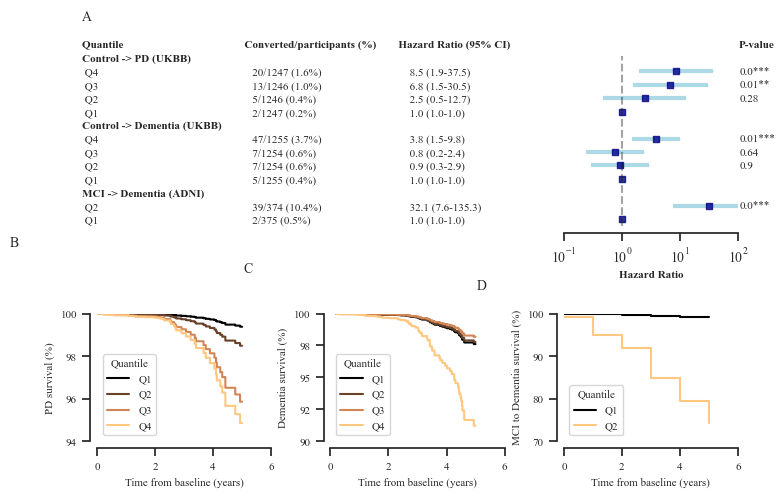

In [247]:
# import importlib
# importlib.reload(myforestplot.forestplot.plot)
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

sns.reset_defaults()
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_theme("notebook", rc={"lines.linewidth": 1.5}) # font_scale=1, 
sns.set_style("white", )
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

mpl.rc('font', family='serif', serif='Times New Roman')
plt.rcParams.update({"savefig.format": 'png'})

from utils.plot import forestplot
# fig, axd = plt.subplot_mosaic([['.', '.', '.', '.', 'upper'], 
#                                ['.', '.', '.', '.', '.'], 
#                                ['lower1','.' ,'lower2', '.','lower3'],
#                                ['.', '.', '.', '.', '.'], 
#                                ['llower1','.' ,'llower2', '.','.'],
#                               ],
#                               gridspec_kw=dict(width_ratios=[1, 0.1, 1, 0.1, 1], height_ratios=[1.3, 0.4, 1, 0.4, 1]), # dict(width_ratios=[1, 1, 1], height_ratios=[1.4, 1]
#                               # layout='constrained',
#                               figsize=(8.27, 7.5))

fig, axd = plt.subplot_mosaic([['.', '.', '.', '.', '.', '.', 'upper', 'upper'], 
                               ['.'] * 8, 
                               ['lower1','lower1' , '.','lower2', 'lower2', '.', 'lower3', 'lower3'],
                               # ['.'] * 8, 
                               # ['llower1','llower1', '.', 'llower2', 'llower2','.', '.', '.'],
                               # ['.'] * 8, 
                               # ['lllower1','lllower1' ,'lllower2','lllower2', 'lllower3', 'lllower3', 'lllower4', 'lllower5']
                              ],
                              gridspec_kw=dict(width_ratios=[1, 1, 0.4, 1, 1, 0.4, 1, 1], height_ratios=[1.6, 0.4, 1.2]), # dict(width_ratios=[1, 1, 1], height_ratios=[1.4, 1]
                              # layout='constrained',
                              figsize=(8.27, 5))
# fig.delaxes(axd['A'])
# fig.delaxes(axd['B'])

sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=5, trim=False)

return_df, ax = forestplot(
              ax=axd['upper'], 
              dataframe=surv_dataframe.sort_values(by='label', ascending=False),  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              capitalize=None,  # Capitalize labels
              pval="pval",  # column containing p-values to be formatted
              annote=["diagnosis_par", "man_est_ci"],  # columns to report on left of plot
              annoteheaders=["Converted/participants (%)", "Hazard Ratio (95% CI)"],  # ^corresponding headers
              rightannote=None, # ["formatted_pval"],  # columns to report on right of plot 
              # right_annoteheaders=["P-value"],  # ^corresponding headers
              groupvar="group",  # column containing group labels
              group_order=[f"Control -> PD (UKBB)", f"Control -> Dementia (UKBB)", f"MCI -> Dementia (ADNI)"],                   
              xlabel="Hazard Ratio",  # x-label title
              xticks=[0.1, 1, 10, 100],  # x-ticks to be printed
              sort=False,  # sort estimates in ascending order
              table=True,  # Format as a table
              logscale=True,
              return_df=True,
              # figsize=(4, 12),
              # color_alt_rows=True,
              # Additional kwargs for customizations
              **{"marker": "s",  # set maker symbol as diamond
                 "markersize": 20,  # adjust marker size
                 "markercolor": "darkblue", # "darkgreen",
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "capsize": 3,
                 "linecolor": "lightblue",
                 "lw": 3,
                 "fontfamily": 'Times New Roman',
                 "fontsize": 8,
                 "xtick_size": 10,  # adjust x-ticker fontsize
                 "ylabel1_size": 8,
                 "grouplab_size": 8,
                 "pval_title_fontsize": 8,
                 "grouplab_size": 8,
                 "xlabel_size": 8,
                 "extrapad": 0,
                 "grouplab_fontweight": 'bold',
                 "xlabel_fontweight": 'bold',
                 "tableheader_fontweight": 'bold',
                 "col_spacing": 5
                }  
              )

ax.axvline(x = 1, color = 'k', linestyle = '--', alpha=0.4)

    
ax.get_yticklabels()[-1].set_text(ax.get_yticklabels()[-1].get_text().replace("Variable", "Quantile"))
V = []
for i in range(len(ax.get_yticklabels())):
    temp = [k for k in ax.get_yticklabels()[i].get_text().split('  ') if not k.strip()=='' ]    
    if '->' in ''.join(temp):
        V.append(temp + ['', ''])
    else:
        V.append(temp)

st = tabulate(V[:-1][::-1], headers=V[-1], tablefmt='orgtbl').split('\n')
tst = st[:1] + st[2:]
tst = tst[::-1]
K = []
for i in range(len(ax.get_yticklabels())):
    bbox_disp = ax.get_yticklabels()[i].get_window_extent()
    (x0, y0), (x1, y1) = ax.transData.inverted().transform(bbox_disp)
    temp = [k.strip().ljust(30, '\u2007') for k in ax.get_yticklabels()[i].get_text().split('  ') if not k.strip()=='' ]  
    if 'Quantile' in  ax.get_yticklabels()[i].get_text():
        ax.text(x=x0 * 1, y=y0+0.1, s= (''.join(temp)),
            fontsize=8, fontfamily='Times New Roman',  
            horizontalalignment="left",
            verticalalignment="bottom",
            fontweight="bold")
    elif '->' in  ax.get_yticklabels()[i].get_text():
        ax.text(x=x0 * 1, y=y0, s= (''.join(temp)),
            fontsize=8, fontfamily='Times New Roman',  
            horizontalalignment="left",
            verticalalignment="bottom",
            fontweight="bold")
    else:
        ax.text(x=x0 * 1, y=y0, s= (' '+''.join(temp)),
            fontsize=8, fontfamily='Times New Roman',  
            horizontalalignment="left",
            verticalalignment="bottom")
        
ax.text(x=x0 * 1, y=y0+2, s='A', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)
ax.set_yticklabels([])
ax.set_xticks([0.1, 1, 10, 100], minor=True)

ax1 = axd['lower1']
ax2 = axd['lower2']
ax3 = axd['lower3']

cph = MAP['ALL_DEMENTIA'][0]
input_data_survival = MAP['ALL_DEMENTIA'][1]
covariate_columns = MAP['ALL_DEMENTIA'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax2 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax2, cmap="copper")
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile', fontsize=8, title_fontsize=8, ncol=1, loc='lower left')
ax2.set_ylabel("Dementia survival (%)")
ax2.set_xlabel("Time from baseline (years)")
# ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{round(100*y)}'))
def formatter(x, pos):
    del pos
    return str(round(x*100))

ax2.yaxis.set_major_formatter(formatter)
# ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax2.set_xticks(ax2.get_xticks(), minor=True)
ax2.set_yticks(ax2.get_yticks(), minor=False)
ax2.set_ylim(top=1)
ax2.set_xlim(left=0)
ax2.text(x=-3, y=1.03, s='C', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)


cph = MAP['PD'][0]
input_data_survival = MAP['PD'][1]
covariate_columns = MAP['PD'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax1 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax1, cmap="copper")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile', fontsize=8, title_fontsize=8, ncol=1, loc='lower left')
ax1.set_ylabel("PD survival (%)")
ax1.set_xlabel("Time from baseline (years)")
ax1.set_xticklabels(ax1.get_xticklabels(), minor=False)
# ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.yaxis.set_major_formatter(formatter)

ax1.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax1.set_xticks(ax1.get_xticks(), minor=True)
ax1.set_yticks(ax1.get_yticks(), minor=False)
ax1.set_ylim(top=1)
ax1.set_xlim(left=0)
ax1.text(x=-3, y=1.03, s='B', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)


cph = MAP['MCI'][0]
input_data_survival = MAP['MCI'][1]
covariate_columns = MAP['MCI'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax3 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax3, cmap="copper")
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile', fontsize=8, title_fontsize=8, ncol=1, loc='lower left')
ax3.set_ylabel("MCI to Dementia survival (%)")
ax3.set_xlabel("Time from baseline (years)")
# ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.yaxis.set_major_formatter(formatter)

ax3.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax3.set_xticks(ax3.get_xticks(), minor=True)
ax3.set_yticks(ax3.get_yticks(), minor=False)
ax3.set_ylim(top=1)
ax3.set_xlim(left=0)
ax3.text(x=-3, y=1.05, s='D', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)

"""
ax4 = axd['llower1']
D = pd.read_csv("/Users/projects_data/project_MLPhenotypesMRIGWAS/evaluation_generated_data/23_03_30/progression_testing/norm_PD_imaging_score&Age_at_image_taken@townsend@Sex@PD_prs/AdjustedScores.csv")
# sns.boxplot(data=D[D['PD_GroupColumn'].isin(['Control', 'Dx_after_baseline', 'Dx_before_baseline'])], x="PD_GroupColumn", y="adjusted@norm_PD_imaging_score@Age_at_image_taken_townsend_Sex_PD_prs", 
#             ax=ax4, color='red')
sns.pointplot(
    data=D, x="PD_GroupColumn", y="adjusted@norm_PD_imaging_score@Age_at_image_taken_townsend_Sex_PD_prs",
    order=['Control', 'Dx_after_baseline', 'Dx_before_baseline'],
    errwidth=0.7,
    capsize=.2, join=False, color="black", ax=ax4, errorbar='ci',
    scale=0.5, # errorbar=("pi", 100),
)
ax4.set_xlabel("PD (UKBB)")
ax4.set_ylabel("adjusted PD imaging score")
ax4.set_xticks(ax4.get_xticks(), minor=True)
ax4.set_yticks(ax4.get_yticks(), minor=False)
ax4.grid()
for label in ax4.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(30)

ax4.text(x=ax4.get_xlim()[0]-0.5, y=ax4.get_ylim()[1]+0.3, s='E', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)


ax5 = axd['llower2']  
D = pd.read_csv("/Users/projects_data/project_MLPhenotypesMRIGWAS/evaluation_generated_data/23_03_30/progression_testing/norm_AD_imaging_score&Age_at_image_taken@townsend@Sex@AD_prs/AdjustedScores.csv")
# sns.boxplot(data=D[D['PD_GroupColumn'].isin(['Control', 'Dx_after_baseline', 'Dx_before_baseline'])], x="PD_GroupColumn", y="adjusted@norm_PD_imaging_score@Age_at_image_taken_townsend_Sex_PD_prs", 
#             ax=ax4, color='red')
sns.pointplot(
    data=D, x="AD_GroupColumn", y="adjusted@norm_AD_imaging_score@Age_at_image_taken_townsend_Sex_AD_prs",
    order=['Control', 'Dx_after_baseline', 'Dx_before_baseline'],
    errwidth=0.7,
    scale=0.5,
    capsize=.2, join=False, color="black", ax=ax5, errorbar='ci'  # errorbar=("pi", 100),
)
ax5.set_xlabel("Dementia (UKBB)")
ax5.set_ylabel("adjusted AD imaging score")
ax5.set_xticks(ax5.get_xticks(), minor=True)
ax5.set_yticks(ax5.get_yticks(), minor=False)
ax5.grid()
for label in ax5.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(30)
    
ax5.text(x=ax5.get_xlim()[0]-0.5, y=ax5.get_ylim()[1]+1.5, s='F', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)





vmax = max([new_results.iloc[:][i].max().max() for i in selected_columns_all])
vmin = min([new_results.iloc[:][i].min().min() for i in selected_columns_all])

nmap = {
    0: 'G', 1: 'H', 2: 'I', 3: 'J', 4: 'K'
}
for i in range(len(selected_columns_all)):
    S = np.array(new_results.iloc[:][selected_columns_all[i]].values, dtype=np.float)
    sns.heatmap(S.round(2), cmap='RdYlGn_r', linewidths=0.5, 
                annot=annot_new_results.iloc[:][selected_columns_all[i]].values, 
                xticklabels=[j.split('&')[0].replace('_', '\n') for j in selected_columns_all[i]], 
                yticklabels= [mapping.get(j, j) for j in new_results.index] if i==0 else [], 
                vmax=vmax,
                vmin=vmin,
                cbar=None,
                fmt='',
                annot_kws={'fontsize': 8, 'fontfamily': 'Times New Roman'},
                ax=axd[f'lllower{i+1}']  )
    ax=axd[f'lllower{i+1}'].set_title(mapping.get(selected_columns_all[i][0].split('&')[1], selected_columns_all[i][0].split('&')[1]))
    for label in axd[f'lllower{i+1}'].get_xticklabels():
        label.set_ha("center")
        label.set_rotation(0)
    amax = axd[f'lllower{i+1}']
    amax.tick_params(axis=u'both', which=u'both',length=0)
    for item in ([amax.title, amax.xaxis.label, amax.yaxis.label] + amax.get_xticklabels() + amax.get_yticklabels()):
        item.set_fontsize(7)
        item.set_fontfamily('Times New Roman')
    amax.spines[['right', 'top']].set_visible(False)
    amax.text(x=amax.get_xlim()[0]-0.1, y=-0.8, s=nmap[i], fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)

        

plt.show()
"""

for amax in [ax1, ax2, ax3, ax4, ax5]:
    for item in ([amax.title, amax.xaxis.label, amax.yaxis.label] + amax.get_xticklabels() + amax.get_yticklabels()):
        item.set_fontsize(8)
        item.set_fontfamily('Times New Roman')
        
fig.savefig("Step3_survival_analysis/Complete_Figure3_effect_size_survival_plots.pdf", bbox_inches="tight")
fig.savefig("Step3_survival_analysis/Complete_Figure3_effect_size_survival_plots.svg", bbox_inches="tight")
fig.savefig('Step3_survival_analysis/Complete_Figure3_effect_size_survival_plots.png', dpi=300, bbox_inches = "tight")

# Extras

In [107]:
# new_results

HELLO
[1]
8


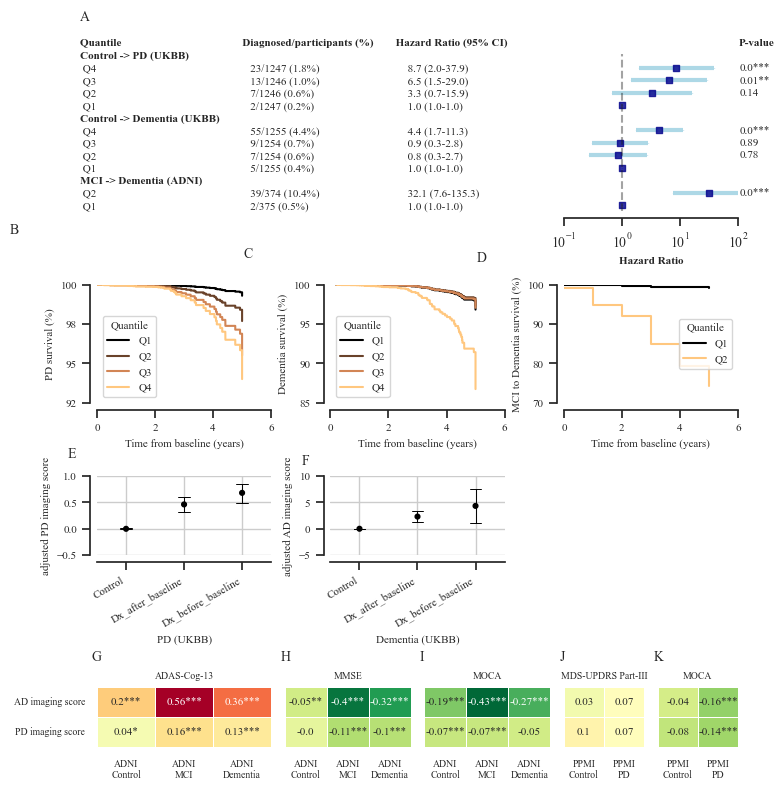

In [108]:
# import importlib
# importlib.reload(myforestplot.forestplot.plot)
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

sns.reset_defaults()
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_theme("notebook", rc={"lines.linewidth": 1.5}) # font_scale=1, 
sns.set_style("white", )
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

mpl.rc('font', family='serif', serif='Times New Roman')
plt.rcParams.update({"savefig.format": 'png'})

from utils.plot import forestplot
# fig, axd = plt.subplot_mosaic([['.', '.', '.', '.', 'upper'], 
#                                ['.', '.', '.', '.', '.'], 
#                                ['lower1','.' ,'lower2', '.','lower3'],
#                                ['.', '.', '.', '.', '.'], 
#                                ['llower1','.' ,'llower2', '.','.'],
#                               ],
#                               gridspec_kw=dict(width_ratios=[1, 0.1, 1, 0.1, 1], height_ratios=[1.3, 0.4, 1, 0.4, 1]), # dict(width_ratios=[1, 1, 1], height_ratios=[1.4, 1]
#                               # layout='constrained',
#                               figsize=(8.27, 7.5))

fig, axd = plt.subplot_mosaic([['.', '.', '.', '.', '.', '.', 'upper', 'upper'], 
                               ['.'] * 8, 
                               ['lower1','lower1' , '.','lower2', 'lower2', '.', 'lower3', 'lower3'],
                               ['.'] * 8, 
                               ['llower1','llower1', '.', 'llower2', 'llower2','.', '.', '.'],
                               ['.'] * 8, 
                               ['lllower1','lllower1' ,'lllower2','lllower2', 'lllower3', 'lllower3', 'lllower4', 'lllower5']
                              ],
                              gridspec_kw=dict(width_ratios=[1, 1, 0.4, 1, 1, 0.4, 1, 1], height_ratios=[1.6, 0.4, 1.2, 0.4, 0.8, 1, 0.6]), # dict(width_ratios=[1, 1, 1], height_ratios=[1.4, 1]
                              # layout='constrained',
                              figsize=(8.27, 9))
# fig.delaxes(axd['A'])
# fig.delaxes(axd['B'])

sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=5, trim=False)

return_df, ax = forestplot(
              ax=axd['upper'], 
              dataframe=surv_dataframe.sort_values(by='label', ascending=False),  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              capitalize=None,  # Capitalize labels
              pval="pval",  # column containing p-values to be formatted
              annote=["diagnosis_par", "man_est_ci"],  # columns to report on left of plot
              annoteheaders=["Diagnosed/participants (%)", "Hazard Ratio (95% CI)"],  # ^corresponding headers
              rightannote=None, # ["formatted_pval"],  # columns to report on right of plot 
              # right_annoteheaders=["P-value"],  # ^corresponding headers
              groupvar="group",  # column containing group labels
              group_order=[f"Control -> PD (UKBB)", f"Control -> Dementia (UKBB)", f"MCI -> Dementia (ADNI)"],                   
              xlabel="Hazard Ratio",  # x-label title
              xticks=[0.1, 1, 10, 100],  # x-ticks to be printed
              sort=False,  # sort estimates in ascending order
              table=True,  # Format as a table
              logscale=True,
              return_df=True,
              # figsize=(4, 12),
              # color_alt_rows=True,
              # Additional kwargs for customizations
              **{"marker": "s",  # set maker symbol as diamond
                 "markersize": 20,  # adjust marker size
                 "markercolor": "darkblue", # "darkgreen",
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "capsize": 3,
                 "linecolor": "lightblue",
                 "lw": 3,
                 "fontfamily": 'Times New Roman',
                 "fontsize": 8,
                 "xtick_size": 10,  # adjust x-ticker fontsize
                 "ylabel1_size": 8,
                 "grouplab_size": 8,
                 "pval_title_fontsize": 8,
                 "grouplab_size": 8,
                 "xlabel_size": 8,
                 "extrapad": 0,
                 "grouplab_fontweight": 'bold',
                 "xlabel_fontweight": 'bold',
                 "tableheader_fontweight": 'bold',
                 "col_spacing": 5
                }  
              )

ax.axvline(x = 1, color = 'k', linestyle = '--', alpha=0.4)

    
ax.get_yticklabels()[-1].set_text(ax.get_yticklabels()[-1].get_text().replace("Variable", "Quantile"))
V = []
for i in range(len(ax.get_yticklabels())):
    temp = [k for k in ax.get_yticklabels()[i].get_text().split('  ') if not k.strip()=='' ]    
    if '->' in ''.join(temp):
        V.append(temp + ['', ''])
    else:
        V.append(temp)

st = tabulate(V[:-1][::-1], headers=V[-1], tablefmt='orgtbl').split('\n')
tst = st[:1] + st[2:]
tst = tst[::-1]
K = []
for i in range(len(ax.get_yticklabels())):
    bbox_disp = ax.get_yticklabels()[i].get_window_extent()
    (x0, y0), (x1, y1) = ax.transData.inverted().transform(bbox_disp)
    temp = [k.strip().ljust(30, '\u2007') for k in ax.get_yticklabels()[i].get_text().split('  ') if not k.strip()=='' ]  
    if 'Quantile' in  ax.get_yticklabels()[i].get_text():
        ax.text(x=x0 * 1, y=y0+0.1, s= (''.join(temp)),
            fontsize=8, fontfamily='Times New Roman',  
            horizontalalignment="left",
            verticalalignment="bottom",
            fontweight="bold")
    elif '->' in  ax.get_yticklabels()[i].get_text():
        ax.text(x=x0 * 1, y=y0, s= (''.join(temp)),
            fontsize=8, fontfamily='Times New Roman',  
            horizontalalignment="left",
            verticalalignment="bottom",
            fontweight="bold")
    else:
        ax.text(x=x0 * 1, y=y0, s= (' '+''.join(temp)),
            fontsize=8, fontfamily='Times New Roman',  
            horizontalalignment="left",
            verticalalignment="bottom")
        
ax.text(x=x0 * 1, y=y0+2, s='A', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)
ax.set_yticklabels([])
ax.set_xticks([0.1, 1, 10, 100], minor=True)

ax1 = axd['lower1']
ax2 = axd['lower2']
ax3 = axd['lower3']

cph = MAP['ALL_DEMENTIA'][0]
input_data_survival = MAP['ALL_DEMENTIA'][1]
covariate_columns = MAP['ALL_DEMENTIA'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax2 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax2, cmap="copper")
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile', fontsize=8, title_fontsize=8, ncol=1, loc='lower left')
ax2.set_ylabel("Dementia survival (%)")
ax2.set_xlabel("Time from baseline (years)")
# ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{round(100*y)}'))
def formatter(x, pos):
    del pos
    return str(round(x*100))

ax2.yaxis.set_major_formatter(formatter)
# ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax2.set_xticks(ax2.get_xticks(), minor=True)
ax2.set_yticks(ax2.get_yticks(), minor=False)
ax2.set_ylim(top=1)
ax2.set_xlim(left=0)
ax2.text(x=-3, y=1.03, s='C', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)



cph = MAP['PD'][0]
input_data_survival = MAP['PD'][1]
covariate_columns = MAP['PD'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax1 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax1, cmap="copper")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile', fontsize=8, title_fontsize=8, ncol=1, loc='lower left')
ax1.set_ylabel("PD survival (%)")
ax1.set_xlabel("Time from baseline (years)")
ax1.set_xticklabels(ax1.get_xticklabels(), minor=False)
# ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.yaxis.set_major_formatter(formatter)

ax1.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax1.set_xticks(ax1.get_xticks(), minor=True)
ax1.set_yticks(ax1.get_yticks(), minor=False)
ax1.set_ylim(top=1)
ax1.set_xlim(left=0)
ax1.text(x=-3, y=1.03, s='B', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)


cph = MAP['MCI'][0]
input_data_survival = MAP['MCI'][1]
covariate_columns = MAP['MCI'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax3 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax3, cmap="copper")
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile', fontsize=8, title_fontsize=8, ncol=1, loc='center right')
ax3.set_ylabel("MCI to Dementia survival (%)")
ax3.set_xlabel("Time from baseline (years)")
# ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.yaxis.set_major_formatter(formatter)

ax3.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax3.set_xticks(ax3.get_xticks(), minor=True)
ax3.set_yticks(ax3.get_yticks(), minor=False)
ax3.set_ylim(top=1)
ax3.set_xlim(left=0)
ax3.text(x=-3, y=1.05, s='D', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)


ax4 = axd['llower1']
D = pd.read_csv("/Users/projects_data/project_MLPhenotypesMRIGWAS/evaluation_generated_data/23_03_30/progression_testing/norm_PD_imaging_score&Age_at_image_taken@townsend@Sex@PD_prs/AdjustedScores.csv")
# sns.boxplot(data=D[D['PD_GroupColumn'].isin(['Control', 'Dx_after_baseline', 'Dx_before_baseline'])], x="PD_GroupColumn", y="adjusted@norm_PD_imaging_score@Age_at_image_taken_townsend_Sex_PD_prs", 
#             ax=ax4, color='red')
sns.pointplot(
    data=D, x="PD_GroupColumn", y="adjusted@norm_PD_imaging_score@Age_at_image_taken_townsend_Sex_PD_prs",
    order=['Control', 'Dx_after_baseline', 'Dx_before_baseline'],
    errwidth=0.7,
    capsize=.2, join=False, color="black", ax=ax4, errorbar='ci',
    scale=0.5, # errorbar=("pi", 100),
)
ax4.set_xlabel("PD (UKBB)")
ax4.set_ylabel("adjusted PD imaging score")
ax4.set_xticks(ax4.get_xticks(), minor=True)
ax4.set_yticks(ax4.get_yticks(), minor=False)
ax4.grid()
for label in ax4.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(30)

ax4.text(x=ax4.get_xlim()[0]-0.5, y=ax4.get_ylim()[1]+0.3, s='E', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)


ax5 = axd['llower2']  
D = pd.read_csv("/Users/projects_data/project_MLPhenotypesMRIGWAS/evaluation_generated_data/23_03_30/progression_testing/norm_AD_imaging_score&Age_at_image_taken@townsend@Sex@AD_prs/AdjustedScores.csv")
# sns.boxplot(data=D[D['PD_GroupColumn'].isin(['Control', 'Dx_after_baseline', 'Dx_before_baseline'])], x="PD_GroupColumn", y="adjusted@norm_PD_imaging_score@Age_at_image_taken_townsend_Sex_PD_prs", 
#             ax=ax4, color='red')
sns.pointplot(
    data=D, x="AD_GroupColumn", y="adjusted@norm_AD_imaging_score@Age_at_image_taken_townsend_Sex_AD_prs",
    order=['Control', 'Dx_after_baseline', 'Dx_before_baseline'],
    errwidth=0.7,
    scale=0.5,
    capsize=.2, join=False, color="black", ax=ax5, errorbar='ci'  # errorbar=("pi", 100),
)
ax5.set_xlabel("Dementia (UKBB)")
ax5.set_ylabel("adjusted AD imaging score")
ax5.set_xticks(ax5.get_xticks(), minor=True)
ax5.set_yticks(ax5.get_yticks(), minor=False)
ax5.grid()
for label in ax5.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(30)
    
ax5.text(x=ax5.get_xlim()[0]-0.5, y=ax5.get_ylim()[1]+1.5, s='F', fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)



for amax in [ax1, ax2, ax3, ax4, ax5]:
    for item in ([amax.title, amax.xaxis.label, amax.yaxis.label] + amax.get_xticklabels() + amax.get_yticklabels()):
        item.set_fontsize(8)
        item.set_fontfamily('Times New Roman')

vmax = max([new_results.iloc[:][i].max().max() for i in selected_columns_all])
vmin = min([new_results.iloc[:][i].min().min() for i in selected_columns_all])

nmap = {
    0: 'G', 1: 'H', 2: 'I', 3: 'J', 4: 'K'
}
for i in range(len(selected_columns_all)):
    S = np.array(new_results.iloc[:][selected_columns_all[i]].values, dtype=np.float)
    sns.heatmap(S.round(2), cmap='RdYlGn_r', linewidths=0.5, 
                annot=annot_new_results.iloc[:][selected_columns_all[i]].values, 
                xticklabels=[j.split('&')[0].replace('_', '\n') for j in selected_columns_all[i]], 
                yticklabels= [mapping.get(j, j) for j in new_results.index] if i==0 else [], 
                vmax=vmax,
                vmin=vmin,
                cbar=None,
                fmt='',
                annot_kws={'fontsize': 8, 'fontfamily': 'Times New Roman'},
                ax=axd[f'lllower{i+1}']  )
    ax=axd[f'lllower{i+1}'].set_title(mapping.get(selected_columns_all[i][0].split('&')[1], selected_columns_all[i][0].split('&')[1]))
    for label in axd[f'lllower{i+1}'].get_xticklabels():
        label.set_ha("center")
        label.set_rotation(0)
    amax = axd[f'lllower{i+1}']
    amax.tick_params(axis=u'both', which=u'both',length=0)
    for item in ([amax.title, amax.xaxis.label, amax.yaxis.label] + amax.get_xticklabels() + amax.get_yticklabels()):
        item.set_fontsize(7)
        item.set_fontfamily('Times New Roman')
    amax.spines[['right', 'top']].set_visible(False)
    amax.text(x=amax.get_xlim()[0]-0.1, y=-0.8, s=nmap[i], fontsize=10, fontfamily='Times New Roman', horizontalalignment="left", verticalalignment="bottom",)

        

plt.show()


# fig.savefig("Step3_survival_analysis/Complete_Figure3_effect_size_survival_plots.pdf", bbox_inches="tight")
# fig.savefig('Step3_survival_analysis/Complete_Figure3_effect_size_survival_plots.png', dpi=300, bbox_inches = "tight")

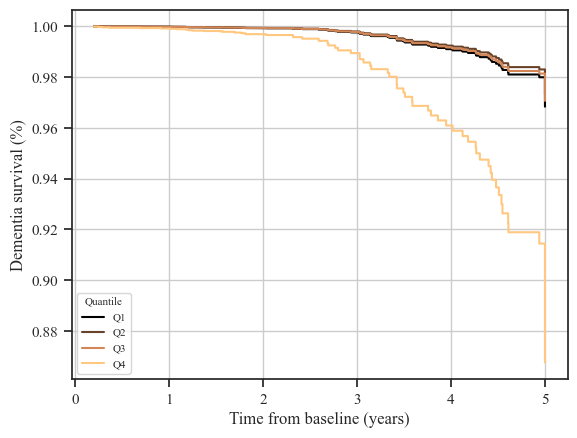

In [109]:
fig, ax = plt.subplots()
cph = MAP['ALL_DEMENTIA'][0]
input_data_survival = MAP['ALL_DEMENTIA'][1]
covariate_columns = MAP['ALL_DEMENTIA'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax2 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax, cmap="copper")
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile', fontsize=8, title_fontsize=8, ncol=1, loc='lower left')
ax2.set_ylabel("Dementia survival (%)")
ax2.set_xlabel("Time from baseline (years)")
plt.grid()

# ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{round(100*y)}'))
def formatter(x, pos):
    del pos
    return str(round(x*100))

plt.show()

In [33]:
new_results

,PPMI_PD&mmse,PPMI_PD&mds_updrspartiii,PPMI_PD&moca,PPMI_PD&id_invicrot1_adas13,PPMI_Control&mmse,PPMI_Control&mds_updrspartiii,PPMI_Control&moca,PPMI_Control&id_invicrot1_adas13,ADNI_MCI&mmse,ADNI_MCI&mds_updrspartiii,ADNI_MCI&moca,ADNI_MCI&id_invicrot1_adas13,ADNI_Control&mmse,ADNI_Control&mds_updrspartiii,ADNI_Control&moca,ADNI_Control&id_invicrot1_adas13,ADNI_Dementia&mmse,ADNI_Dementia&mds_updrspartiii,ADNI_Dementia&moca,ADNI_Dementia&id_invicrot1_adas13
norm_AD_imaging_score,NaN,0.073752,-0.163882,NaN,NaN,0.034466,-0.03849,NaN,-0.403847,NaN,-0.42799,0.556365,-0.053784,NaN,-0.188975,0.196156,-0.317305,NaN,-0.266578,0.360774
norm_PD_imaging_score,NaN,0.067505,-0.142211,NaN,NaN,0.099658,-0.077402,NaN,-0.105949,NaN,-0.073376,0.160167,-0.004944,NaN,-0.065582,0.044406,-0.100792,NaN,-0.051014,0.127127


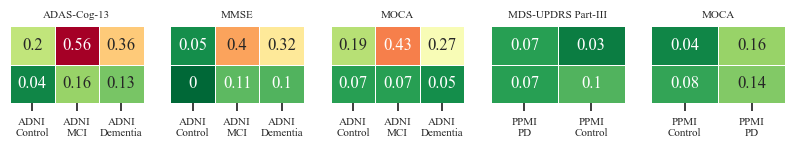

In [34]:
import anndata as ad

# calculate the Pearson's correlation between two variables
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
# seed random number generator

# calculate Pearson's correlation
# print('Pearsons correlation: %.3f' % corr)

adata = ad.read("/Users/projects_data/project_MLPhenotypesMRIGWAS/ml_generated_data/23_03_30/preprocessed_data/minmax_adata.h5ad")
from pathlib import Path
ml_generated_dir =  Path("/Users/EssentialCodeBase/project_MLPhenotypesMRIGWAS/block1_BaselineClassification/training/23_03_30/results_data")

ad_imaging_path = ml_generated_dir / "predictiveAnalysis/classification_detailed_metrics/phenotype_data/replication_ensemble_ad_imaging_probability_scores.csv"
pd_imaging_path = ml_generated_dir / "predictiveAnalysis/classification_detailed_metrics/phenotype_data/replication_ensemble_pd_imaging_probability_scores.csv"
ad2_imaging_data = pd.read_csv(ml_generated_dir / "predictiveAnalysis/classification_detailed_metrics/phenotype_data/ensemble_ad_imaging_probability_scores.csv")
pd2_imaging_data = pd.read_csv(ml_generated_dir / "predictiveAnalysis/classification_detailed_metrics/phenotype_data/ensemble_pd_imaging_probability_scores.csv")

ad_imaging_data = pd.read_csv(ad_imaging_path)
pd_imaging_data = pd.read_csv(pd_imaging_path)
ad_score_dictionary = dict(zip(list(ad_imaging_data['ID']), list(ad_imaging_data['rep_y_probas1'])))
ad_score_dictionary.update(dict(zip(list(ad2_imaging_data['ID']), list(ad2_imaging_data['y_probas1']))))
pd_score_dictionary = dict(zip(list(pd_imaging_data['ID']), list(pd_imaging_data['rep_y_probas1'])))
pd_score_dictionary.update(dict(zip(list(pd2_imaging_data['ID']), list(pd2_imaging_data['y_probas1']))))
from collections import defaultdict
all_study_diagnosis = adata.obs['study_diagnosis'].unique()
adata.obs['AD_imaging_score'] = adata.obs.index.map(lambda x: ad_score_dictionary.get(x, None))
adata.obs['PD_imaging_score'] = adata.obs.index.map(lambda x: pd_score_dictionary.get(x, None))
adata.obs['norm_AD_imaging_score'] = adata.obs['AD_imaging_score'].map(lambda x: np.log2(x / (1 - x)))
adata.obs['norm_PD_imaging_score'] = adata.obs['PD_imaging_score'].map(lambda x: np.log2(x / (1 - x)))
correlation_columns1 = ['norm_AD_imaging_score', 'norm_PD_imaging_score', ]
correlation_columns2 = ['mmse', 'mds_updrspartiii', 'moca', 'id_invicrot1_adas13', 'id_invicrot1_adas13']
results = defaultdict(list)
all_study_diagnosis = [
                'PPMI_PD',
                'PPMI_Control',
                'ADNI_MCI',
                'ADNI_Control',
                'ADNI_Dementia',
]
for study_diagnosis in all_study_diagnosis:
    for col1 in correlation_columns1:
        for col2 in correlation_columns2:
            T = adata.obs[adata.obs['study_diagnosis']==study_diagnosis].copy()
            seed(1)
            # print (col1, col2, study_diagnosis)
            # print (T[col1].isna().sum(), T[col2].isna().sum())
            # print (len(T))
            T = T.dropna(subset=[col1, col2])
            
            if len(T) <=0:
                corr, pvalue = None, None
            else:
                corr, pvalue = pearsonr(T[col1], T[col2])
            results['study_diagnosis'].append(study_diagnosis)
            results['column1'].append(col1)
            results['column2'].append(col2)
            results[f'correlation'].append(corr)
            results[f'pvalue'].append(pvalue)
            
Y = pd.DataFrame(results).copy()
Y['q'] = Y['study_diagnosis'] + '&'+ Y['column2']
Y['id'] = Y['column1']
Y['v'] = Y['correlation']
new_results = pd.DataFrame(index=Y['id'].unique(), columns=Y['q'].unique())
for i in range(len(Y)):
    new_results.loc[Y.iloc[i]['id']][Y.iloc[i]['q']] = Y.iloc[i]['v']

selected_columns_all = [
    ["ADNI_Control&id_invicrot1_adas13",
    "ADNI_MCI&id_invicrot1_adas13", 
    "ADNI_Dementia&id_invicrot1_adas13", ],
    
    ["ADNI_Control&mmse",
    "ADNI_MCI&mmse", 
    "ADNI_Dementia&mmse", ],
    
    ["ADNI_Control&moca", 
    "ADNI_MCI&moca", 
    "ADNI_Dementia&moca", ],
    
    ["PPMI_PD&mds_updrspartiii", 
    'PPMI_Control&mds_updrspartiii',], 

    ['PPMI_Control&moca',
    'PPMI_PD&moca',]
]

mapping = {
    "id_invicrot1_adas13": "ADAS-Cog-13",
    "mmse": "MMSE",
    "moca": "MOCA",
    "mds_updrspartiii": "MDS-UPDRS Part-III"
    
}
from mpl_toolkits.axisartist.parasite_axes import SubplotHost
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

vmax = max([new_results.iloc[:][i].abs().max().max() for i in selected_columns_all])
vmin = min([new_results.iloc[:][i].abs().min().min() for i in selected_columns_all])

fig, axs = plt.subplots(ncols=5, figsize=(10, 1), sharey=True)
for i in range(len(selected_columns_all)):
    S = np.array(new_results.iloc[:][selected_columns_all[i]].values, dtype=np.float)
    sns.heatmap(np.abs(S.round(2)), cmap='RdYlGn_r', linewidths=0.5, annot=True, 
                xticklabels=[j.split('&')[0].replace('_', '\n') for j in selected_columns_all[i]], 
                yticklabels= new_results.index if i==0 else [], 
                vmax=vmax,
                vmin=vmin,
                cbar=None,
                ax=axs[i])
    axs[i].set_title(mapping.get(selected_columns_all[i][0].split('&')[1], selected_columns_all[i][0].split('&')[1]))
    for label in axs[i].get_xticklabels():
        label.set_ha("center")
        label.set_rotation(0)
    amax = axs[i]
    for item in ([amax.title, amax.xaxis.label, amax.yaxis.label] + amax.get_xticklabels() + amax.get_yticklabels()):
        item.set_fontsize(8)
        item.set_fontfamily('Times New Roman')

plt.show()

In [ ]:
# 30 * 159 = 530 (55) + 200 (40)
# 15 * 159 = 265 (38)
# 26 * 129 = 374 (52)

0.5563647014484915

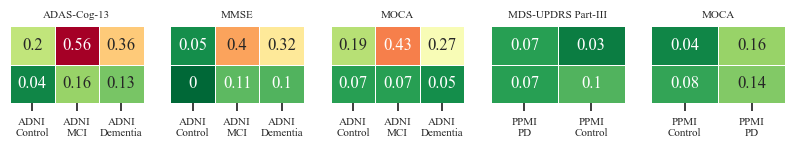

In [342]:
new_results.iloc[:][selected_columns].values


array([[0.19615560626827688, -0.05378358608555699, -0.18897490085630128,
        0.3607744414930522, -0.31730519247065675, -0.26657800378614543,
        0.5563647014484915, -0.4038471385953439, -0.4279895332531991,
        0.03446572432620468, -0.03848993458255649, 0.0737517461527755,
        -0.1638820231815454],
       [0.04440649185433381, -0.004943966744691132, -0.06558248682999433,
        0.12712658755632694, -0.10079221845132558, -0.051013807494512856,
        0.1601671707242905, -0.10594913544949834, -0.07337631884447482,
        0.0996583311265741, -0.07740195377269346, 0.06750451626056644,
        -0.14221100673024722]], dtype=object)

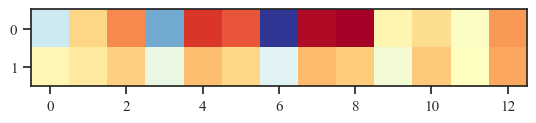

In [343]:
# plt.imshow(new_results.iloc[:][selected_columns], cmap ="RdYlBu")
# sns.heatmap(S, annot=True)
plt.imshow(S, cmap ="RdYlBu")
plt.show()

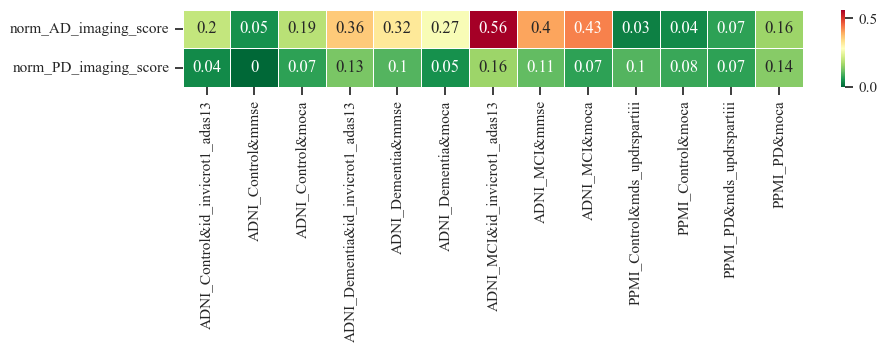

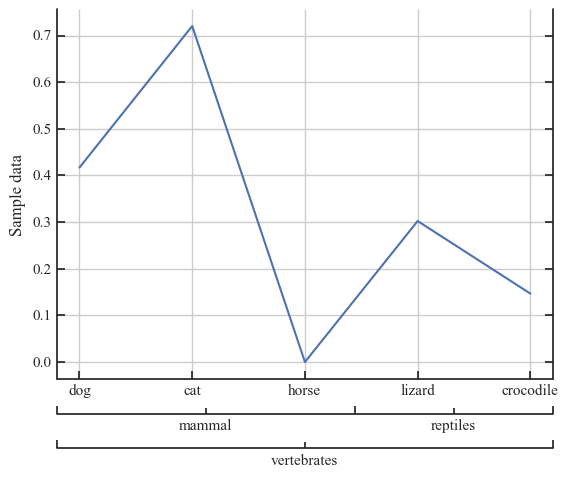

In [349]:
fig1 = plt.figure()
ax1 = SubplotHost(fig1, 111)
fig1.add_subplot(ax1)

# Some data
x = np.arange(1,6)
y = np.random.random(len(x))

# First X-axis
ax1.plot(x, y)
ax1.set_xticks(x)
ax1.set_xticklabels(['dog', 'cat', 'horse', 'lizard', 'crocodile'])
#ax1.xaxis.set_label_text('First X-axis') # Uncomment to label axis
ax1.yaxis.set_label_text("Sample data")

# Second X-axis
ax2 = ax1.twiny()
offset = 0, -25 # Position of the second axis
new_axisline = ax2.get_grid_helper().new_fixed_axis
ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
ax2.axis["top"].set_visible(False)

ax2.set_xticks([0.0, 0.6, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.3, 0.8]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['mammal', 'reptiles']))

# Third X-axis
ax3 = ax1.twiny()
offset = 0, -50
new_axisline = ax3.get_grid_helper().new_fixed_axis
ax3.axis["bottom"] = new_axisline(loc="bottom", axes=ax3, offset=offset)
ax3.axis["top"].set_visible(False)

ax3.set_xticks([0.0, 1.0])
ax3.xaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_minor_locator(ticker.FixedLocator([0.5]))
ax3.xaxis.set_minor_formatter(ticker.FixedFormatter(['vertebrates']))

ax1.grid(1)
plt.show()

In [347]:
ax.get_xticklabels()

[Text(0.5, 0, 'ADNI_Control&id_invicrot1_adas13'),
 Text(1.5, 0, 'ADNI_Control&mmse'),
 Text(2.5, 0, 'ADNI_Control&moca'),
 Text(3.5, 0, 'ADNI_Dementia&id_invicrot1_adas13'),
 Text(4.5, 0, 'ADNI_Dementia&mmse'),
 Text(5.5, 0, 'ADNI_Dementia&moca'),
 Text(6.5, 0, 'ADNI_MCI&id_invicrot1_adas13'),
 Text(7.5, 0, 'ADNI_MCI&mmse'),
 Text(8.5, 0, 'ADNI_MCI&moca'),
 Text(9.5, 0, 'PPMI_Control&mds_updrspartiii'),
 Text(10.5, 0, 'PPMI_Control&moca'),
 Text(11.5, 0, 'PPMI_PD&mds_updrspartiii'),
 Text(12.5, 0, 'PPMI_PD&moca')]

In [ ]:
[col for col in new_results.columns if col.split('&').isin([])]

In [244]:
new_results[]

,PPMI_GENUN&mmse,PPMI_GENUN&mds_updrspartiii,PPMI_GENUN&moca,PPMI_GENUN&id_invicrot1_adas13,PPMI_PD&mmse,PPMI_PD&mds_updrspartiii,PPMI_PD&moca,PPMI_PD&id_invicrot1_adas13,PPMI_Control&mmse,PPMI_Control&mds_updrspartiii,...,PPMI_None&moca,PPMI_None&id_invicrot1_adas13,PPMI_GENPD&mmse,PPMI_GENPD&mds_updrspartiii,PPMI_GENPD&moca,PPMI_GENPD&id_invicrot1_adas13,ADNI_nan&mmse,ADNI_nan&mds_updrspartiii,ADNI_nan&moca,ADNI_nan&id_invicrot1_adas13
norm_AD_imaging_score,NaN,0.115103,-0.134606,NaN,NaN,0.073752,-0.163882,NaN,NaN,0.034466,...,-0.450898,NaN,NaN,0.049267,0.019946,NaN,-0.642498,NaN,-0.611381,0.811143
norm_PD_imaging_score,NaN,0.119324,-0.052447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.24744,NaN,NaN,0.282799,-0.156704,NaN,-0.207952,NaN,-0.182821,0.209724


In [236]:
Y[['id', 'q', 'v']].set_index(['id', 'q'])['v'].shape

(120,)

In [238]:
Y[['id', 'q', 'v']].set_index(['id', 'q'])['v'].drop_duplicates()

id                     q                                
norm_AD_imaging_score  PPMI_GENUN&mmse                           NaN
                       PPMI_GENUN&mds_updrspartiii          0.115103
                       PPMI_GENUN&moca                     -0.134606
norm_PD_imaging_score  PPMI_GENUN&mds_updrspartiii          0.119324
                       PPMI_GENUN&moca                     -0.052447
norm_AD_imaging_score  PPMI_PD&mds_updrspartiii             0.073752
                       PPMI_PD&moca                        -0.163882
                       PPMI_Control&mds_updrspartiii        0.034466
                       PPMI_Control&moca                   -0.038490
                       PPMI_PRODROMA&mds_updrspartiii      -0.064156
                       PPMI_PRODROMA&moca                  -0.231053
norm_PD_imaging_score  PPMI_PRODROMA&mds_updrspartiii       0.230860
                       PPMI_PRODROMA&moca                  -0.030544
norm_AD_imaging_score  ADNI_MCI&mmse          

In [234]:
Y[['id', 'q', 'v']].set_index(['id', 'q'])['v'].drop_duplicates().unstack()

q,PPMI_GENUN&mmse,PPMI_GENUN&mds_updrspartiii,PPMI_GENUN&moca,PPMI_PD&mds_updrspartiii,PPMI_PD&moca,PPMI_Control&mds_updrspartiii,PPMI_Control&moca,PPMI_PRODROMA&mds_updrspartiii,PPMI_PRODROMA&moca,ADNI_MCI&mmse,...,ADNI_Dementia&id_invicrot1_adas13,PPMI_SWEDD&mds_updrspartiii,PPMI_SWEDD&moca,PPMI_None&mds_updrspartiii,PPMI_None&moca,PPMI_GENPD&mds_updrspartiii,PPMI_GENPD&moca,ADNI_nan&mmse,ADNI_nan&moca,ADNI_nan&id_invicrot1_adas13
id,,,,,,,,,,,,,,,,,,,,,
norm_AD_imaging_score,NaN,0.115103,-0.134606,0.073752,-0.163882,0.034466,-0.03849,-0.064156,-0.231053,-0.403847,...,NaN,0.087590,-0.133044,0.475234,-0.450898,0.049267,0.019946,-0.642498,-0.611381,0.811143
norm_PD_imaging_score,NaN,0.119324,-0.052447,NaN,NaN,NaN,NaN,0.230860,-0.030544,-0.105949,...,0.127127,-0.103311,-0.098977,0.143593,0.247440,0.282799,-0.156704,-0.207952,-0.182821,0.209724


In [227]:
# Y[['id', 'q', 'v']].set_index(['id', 'q'])['v'].unstack().reset_index()

In [239]:
pd.DataFrame(results)

,study_diagnosis,column1,column2,correlation,pvalue
0,PPMI_GENUN,norm_AD_imaging_score,mmse,NaN,NaN
1,PPMI_GENUN,norm_AD_imaging_score,mds_updrspartiii,0.115103,2.247999e-02
2,PPMI_GENUN,norm_AD_imaging_score,moca,-0.134606,7.310021e-03
3,PPMI_GENUN,norm_AD_imaging_score,id_invicrot1_adas13,NaN,NaN
4,PPMI_GENUN,norm_AD_imaging_score,id_invicrot1_adas13,NaN,NaN
...,...,...,...,...,...
115,ADNI_nan,norm_PD_imaging_score,mmse,-0.207952,8.692711e-10
116,ADNI_nan,norm_PD_imaging_score,mds_updrspartiii,NaN,NaN
117,ADNI_nan,norm_PD_imaging_score,moca,-0.182821,9.513130e-08
118,ADNI_nan,norm_PD_imaging_score,id_invicrot1_adas13,0.209724,1.480901e-01


In [211]:
pd.DataFrame(results)

,study_diagnosis,column1,column2,correlation,pvalue
0,PPMI_GENUN,norm_AD_imaging_score,mds_updrspartiii,0.115103,2.247999e-02
1,PPMI_GENUN,norm_AD_imaging_score,moca,-0.134606,7.310021e-03
2,PPMI_GENUN,norm_PD_imaging_score,mds_updrspartiii,0.119324,1.796050e-02
3,PPMI_GENUN,norm_PD_imaging_score,moca,-0.052447,2.978329e-01
4,PPMI_PD,norm_AD_imaging_score,mds_updrspartiii,0.073752,5.386051e-02
5,PPMI_PD,norm_AD_imaging_score,moca,-0.163882,1.651949e-05
6,PPMI_Control,norm_AD_imaging_score,mds_updrspartiii,0.034466,6.014712e-01
7,PPMI_Control,norm_AD_imaging_score,moca,-0.038490,5.596841e-01
8,PPMI_PRODROMA,norm_AD_imaging_score,mds_updrspartiii,-0.064156,5.844879e-01
9,PPMI_PRODROMA,norm_AD_imaging_score,moca,-0.231053,4.610319e-02


In [161]:
adata.obs.groupby('study_diagnosis')# ['mmse']

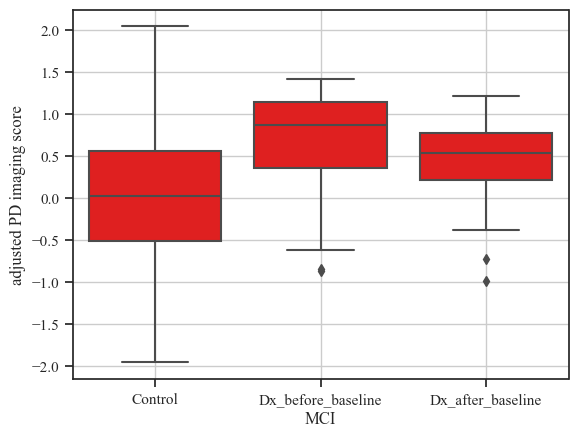

In [123]:
fig, ax = plt.subplots()
sns.boxplot(data=D[D['PD_GroupColumn'].isin(['Control', 'Dx_after_baseline', 'Dx_before_baseline'])], x="PD_GroupColumn", y="adjusted@norm_PD_imaging_score@Age_at_image_taken_townsend_Sex_PD_prs", ax=ax, color='red')
ax.set_xlabel(disease)
ax.set_ylabel("adjusted PD imaging score")
ax.grid()
plt.show()

In [ ]:
sns.pointplot(
    data=D, x="PD_GroupColumn", y="adjusted@norm_PD_imaging_score@Age_at_image_taken_townsend_Sex_PD_prs",
    order=['Control', 'Dx_after_baseline', 'Dx_before_baseline'],
    capsize=.4, join=False, color="black", ax=ax, errorbar='ci'  # errorbar=("pi", 100),
)

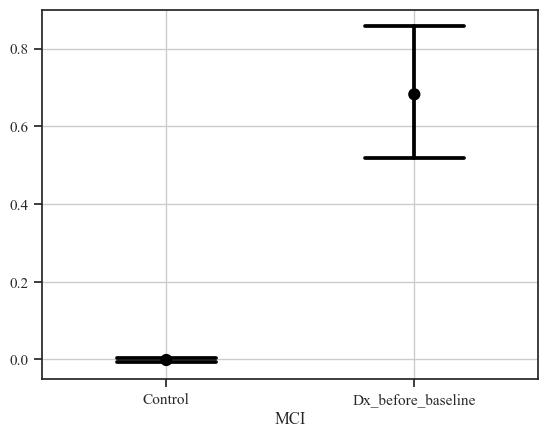

In [118]:
fig, ax = plt.subplots()
sns.pointplot(
    data=D[D['PD_GroupColumn'].isin(['Control', 'Dx_before_baseline'])], x="PD_GroupColumn", y="adjusted@norm_PD_imaging_score@Age_at_image_taken_townsend_Sex_PD_prs",
    order=['Control', 'Dx_before_baseline'],
    capsize=.4, join=False, color="black", ax=ax, errorbar='ci'  # errorbar=("pi", 100),
)
ax.set_xlabel(disease)
ax.set_ylabel("")
ax.grid()
plt.show()

In [105]:
D

,index,Age_at_image_taken,townsend,Sex,PD_prs,norm_PD_imaging_score,adjusted@norm_PD_imaging_score@Age_at_image_taken_townsend_Sex_PD_prs,PD_GroupColumn,ALL_DEMENTIA_GroupColumn,PARKINSONISM_GroupColumn,AD_GroupColumn,MS_GroupColumn,STROKE_GroupColumn,OtMOVEMENT_GroupColumn,DYSTONIA_GroupColumn
0,0,71,-2.588870,1,0.296698,0.352613,-1.027142,Control,Control,Control,Control,Control,Control,Control,Control
1,1,65,-3.391840,1,0.550669,0.935517,-0.465804,Control,Control,Control,Control,Control,Control,Control,Control
2,2,70,-3.210510,0,-0.720802,2.047582,0.985306,Control,Control,Control,Control,Control,Control,Control,Control
3,3,75,-2.612910,0,0.709863,1.555980,0.475665,Control,Control,Control,Control,Control,Control,Control,Control
4,4,63,-2.326780,0,0.125215,1.865961,0.776910,Control,Control,Control,Control,Control,Control,Control,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41485,46207,73,-1.018280,1,0.375336,1.987453,0.618721,Control,Control,Control,Control,Control,Control,Control,Control
41486,46208,70,-0.434508,0,-0.116136,1.995814,0.936140,Control,Control,Control,Control,Control,Control,Control,Control
41487,46209,70,-4.207120,0,-0.062148,0.772686,-0.309511,Control,Control,Control,Control,Control,Control,Control,Control
41488,46210,53,0.703479,0,-1.858450,1.074039,0.025954,Control,Control,Control,Control,Control,Control,Control,Control


In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.datasets import load_waltons
from lifelines.plotting import add_at_risk_counts

temp = input_data_survival[input_data_survival['quantiles_norm_AD_imaging_score']=='Q0']
ax = plt.subplot(111)

kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(temp['daysFromDiagnosis_image_taken_ALL_DEMENTIA'], temp['Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'], label='Q0').plot_survival_function(ax=ax)

temp = input_data_survival[input_data_survival['quantiles_norm_AD_imaging_score']=='Q3']
kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(temp['daysFromDiagnosis_image_taken_ALL_DEMENTIA'], temp['Status_daysFromDiagnosis_image_taken_ALL_DEMENTIA'], label='Q3').plot_survival_function(ax=ax)




add_at_risk_counts(kmf_exp, kmf_control, ax=ax)
plt.tight_layout()
plt.show()

from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf_control.confidence_interval_)
print (median_ci)
np.mean(kmf_control.confidence_interval_, axis=0)

# median_ci = median_survival_times(kmf_exp.confidence_interval_)
np.mean(kmf_exp.confidence_interval_, axis=0)
# print (median_ci)
kmf_exp.median_survival_time_
cph = MAP['ALL_DEMENTIA'][0]
input_data_survival = MAP['ALL_DEMENTIA'][1]
covariate_columns = MAP['ALL_DEMENTIA'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), cmap="copper")
plt.show()
cph.predict_percentile(input_data_survival, p=0.975)

In [ ]:
set_xticks

In [108]:
temp[0].ljust(10, '*')

'Quantile**'

In [64]:
ax.get_yaxis().majorTicks[0]

In [65]:
ax.get_yticks()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [66]:
return_df['yticklabel']

0       Q1                           2/374 (0.5%)   ...
1       Q2                           39/336 (11.6%) ...
2                                MCI -> Dementia (ADNI)
3       Q1                           5/1248 (0.4%)  ...
4       Q2                           3/1250 (0.2%)  ...
5       Q3                           8/1245 (0.6%)  ...
6       Q4                           58/1195 (4.9%) ...
7                            Control -> Dementia (UKBB)
8       Q1                           2/1245 (0.2%)  ...
9       Q2                           7/1239 (0.6%)  ...
10      Q3                           13/1233 (1.1%) ...
11      Q4                           23/1224 (1.9%) ...
12                                 Control -> PD (UKBB)
13    Variable                       Diagnosed/parti...
Name: yticklabel, dtype: object

In [6]:
x_loc = ax.get_yticklabels()[0].get_position()[0]
y_loc = ax.get_yticklabels()[0].get_position()[1]

(0, 0)

In [63]:
ax.get_yticklabels()# [0].get_position()


[Text(0, 0, '  Q1                           2/374 (0.5%)                   1.0 (1.0-1.0)        '),
 Text(0, 1, '  Q2                           39/336 (11.6%)                 33.5 (7.9-141.3)     '),
 Text(0, 2, 'MCI -> Dementia (ADNI)'),
 Text(0, 3, '  Q1                           5/1248 (0.4%)                  1.0 (1.0-1.0)        '),
 Text(0, 4, '  Q2                           3/1250 (0.2%)                  0.5 (0.1-2.0)        '),
 Text(0, 5, '  Q3                           8/1245 (0.6%)                  1.1 (0.4-3.4)        '),
 Text(0, 6, '  Q4                           58/1195 (4.9%)                 3.7 (1.4-9.5)        '),
 Text(0, 7, 'Control -> Dementia (UKBB)'),
 Text(0, 8, '  Q1                           2/1245 (0.2%)                  1.0 (1.0-1.0)        '),
 Text(0, 9, '  Q2                           7/1239 (0.6%)                  3.3 (0.7-16.2)       '),
 Text(0, 10, '  Q3                           13/1233 (1.1%)                 6.5 (1.4-28.9)       '),
 Text(0, 11, '  Q

In [73]:
first_yticklab = ax.get_yaxis().majorTicks[-1]

In [76]:
first_yticklab.label.get_window_extent()

Bbox([[71.93848039215692, 447.9921463274045], [432.8134803921569, 457.3202713274045]])

In [67]:
ax.get_yticklabels()[0].get_window_extent()

Bbox([[71.93848039215692, 237.57503705533597], [353.0634803921569, 247.90316205533597]])

In [70]:
bbox_disp = ax.get_yticklabels()[0].get_window_extent()
(x0, _), (x1, _) = ax.transData.inverted().transform(bbox_disp)

In [78]:
x0, x1

(1.9939008268281785e-09, 5.938366064355465e-05)

In [68]:
ax.get_yticklabels()[1].get_window_extent()

Bbox([[71.93848039215692, 253.71469449934125], [366.4384803921569, 264.04281949934125]])

In [52]:
ax.get_yticklabels()[1].get_bbox_patch()

In [7]:
from tabulate import tabulate

In [4]:
setting_labs

[Text(0.8, 0, '  Q1                      2/374 (0.5%)              1.0 (1.0-1.0)'),
 Text(0.8, 1, '  Q2                      39/336 (11.6%)            33.5 (7.9-141.3)'),
 Text(0.8, 2, 'MCI -> Dementia (ADNI)'),
 Text(0.8, 3, '  Q1                      5/1248 (0.4%)             1.0 (1.0-1.0)'),
 Text(0.8, 4, '  Q2                      3/1250 (0.2%)             0.5 (0.1-2.0)'),
 Text(0.8, 5, '  Q3                      8/1245 (0.6%)             1.1 (0.4-3.4)'),
 Text(0.8, 6, '  Q4                      58/1195 (4.9%)            3.7 (1.4-9.5)'),
 Text(0.8, 7, 'Control -> Dementia (UKBB)'),
 Text(0.8, 8, '  Q1                      2/1245 (0.2%)             1.0 (1.0-1.0)'),
 Text(0.8, 9, '  Q2                      7/1239 (0.6%)             3.3 (0.7-16.2)'),
 Text(0.8, 10, '  Q3                      13/1233 (1.1%)            6.5 (1.4-28.9)'),
 Text(0.8, 11, '  Q4                      23/1224 (1.9%)            8.4 (1.9-36.8)'),
 Text(0.8, 12, 'Control -> PD (UKBB)'),
 Text(0.8, 13, 'Quantile  

In [105]:
tst[::-1]

['| Quantile                   |  Diagnosed/participants (%)   |  Hazard Ratio (95% CI)   |',
 '| Control -> PD (UKBB)       |                               |                          |',
 '| Q4                         | 23/1224 (1.9%)                | 8.4 (1.9-36.8)           |',
 '| Q3                         | 13/1233 (1.1%)                | 6.5 (1.4-28.9)           |',
 '| Q2                         | 7/1239 (0.6%)                 | 3.3 (0.7-16.2)           |',
 '| Q1                         | 2/1245 (0.2%)                 | 1.0 (1.0-1.0)            |',
 '| Control -> Dementia (UKBB) |                               |                          |',
 '| Q4                         | 58/1195 (4.9%)                | 3.7 (1.4-9.5)            |',
 '| Q3                         | 8/1245 (0.6%)                 | 1.1 (0.4-3.4)            |',
 '| Q2                         | 3/1250 (0.2%)                 | 0.5 (0.1-2.0)            |',
 '| Q1                         | 5/1248 (0.4%)              

In [17]:
ax.get_yticklabels()

[Text(0.8, 0, '  Q1                      2/374 (0.5%)              1.0 (1.0-1.0)'),
 Text(0.8, 1, '  Q2                      39/336 (11.6%)            33.5 (7.9-141.3)'),
 Text(0.8, 2, 'MCI -> Dementia (ADNI)'),
 Text(0.8, 3, '  Q1                      5/1248 (0.4%)             1.0 (1.0-1.0)'),
 Text(0.8, 4, '  Q2                      3/1250 (0.2%)             0.5 (0.1-2.0)'),
 Text(0.8, 5, '  Q3                      8/1245 (0.6%)             1.1 (0.4-3.4)'),
 Text(0.8, 6, '  Q4                      58/1195 (4.9%)            3.7 (1.4-9.5)'),
 Text(0.8, 7, 'Control -> Dementia (UKBB)'),
 Text(0.8, 8, '  Q1                      2/1245 (0.2%)             1.0 (1.0-1.0)'),
 Text(0.8, 9, '  Q2                      7/1239 (0.6%)             3.3 (0.7-16.2)'),
 Text(0.8, 10, '  Q3                      13/1233 (1.1%)            6.5 (1.4-28.9)'),
 Text(0.8, 11, '  Q4                      23/1224 (1.9%)            8.4 (1.9-36.8)'),
 Text(0.8, 12, 'Control -> PD (UKBB)'),
 Text(0.8, 13, 'Quantile  

In [61]:
st = tabulate(V[:-1][::-1], headers=V[-1], tablefmt='orgtbl')



In [63]:
print (st)

| Quantile                   | Diagnosed/participants (%)   | Hazard Ratio (95% CI)   |
|----------------------------+------------------------------+-------------------------|
| Control -> PD (UKBB)       |                              |                         |
| Q4                         | 23/1224 (1.9%)               | 8.4 (1.9-36.8)          |
| Q3                         | 13/1233 (1.1%)               | 6.5 (1.4-28.9)          |
| Q2                         | 7/1239 (0.6%)                | 3.3 (0.7-16.2)          |
| Q1                         | 2/1245 (0.2%)                | 1.0 (1.0-1.0)           |
| Control -> Dementia (UKBB) |                              |                         |
| Q4                         | 58/1195 (4.9%)               | 3.7 (1.4-9.5)           |
| Q3                         | 8/1245 (0.6%)                | 1.1 (0.4-3.4)           |
| Q2                         | 3/1250 (0.2%)                | 0.5 (0.1-2.0)           |
| Q1                         | 5

In [67]:
len(tst)

14

In [66]:
print (tst)

['| Q1                         | 2/374 (0.5%)                 | 1.0 (1.0-1.0)           |', '| Q2                         | 39/336 (11.6%)               | 33.5 (7.9-141.3)        |', '| MCI -> Dementia (ADNI)     |                              |                         |', '| Q1                         | 5/1248 (0.4%)                | 1.0 (1.0-1.0)           |', '| Q2                         | 3/1250 (0.2%)                | 0.5 (0.1-2.0)           |', '| Q3                         | 8/1245 (0.6%)                | 1.1 (0.4-3.4)           |', '| Q4                         | 58/1195 (4.9%)               | 3.7 (1.4-9.5)           |', '| Control -> Dementia (UKBB) |                              |                         |', '| Q1                         | 2/1245 (0.2%)                | 1.0 (1.0-1.0)           |', '| Q2                         | 7/1239 (0.6%)                | 3.3 (0.7-16.2)          |', '| Q3                         | 13/1233 (1.1%)               | 6.5 (1.4-28.9)          |'

In [ ]:
pd.DataFrame(V[:-1][::-1], columns=V[-1])

In [35]:
from tabulate import tabulate
st = tabulate([['Alice', 24], ['Bob', 19]], headers=['Name', 'Age'], tablefmt='orgtbl')


In [37]:
print (st)

| Name   |   Age |
|--------+-------|
| Alice  |    24 |
| Bob    |    19 |


In [20]:
ax.get_yticklabels()[0].get_text()

'  Q1                        2/374 (0.5%)                1.0 (1.0-1.0)'

['Q1', '2/374 (0.5%)', '1.0 (1.0-1.0)']

In [12]:
setting_labs

[Text(0, 0, '  Q1                        2/374 (0.5%)                1.0 (1.0-1.0)        '),
 Text(0, 1, '  Q2                        39/336 (11.6%)              33.5 (7.9-141.3)     '),
 Text(0, 2, 'MCI -> Dementia (ADNI)'),
 Text(0, 3, '  Q1                        5/1248 (0.4%)               1.0 (1.0-1.0)        '),
 Text(0, 4, '  Q2                        3/1250 (0.2%)               0.5 (0.1-2.0)        '),
 Text(0, 5, '  Q3                        8/1245 (0.6%)               1.1 (0.4-3.4)        '),
 Text(0, 6, '  Q4                        58/1195 (4.9%)              3.7 (1.4-9.5)        '),
 Text(0, 7, 'Control -> Dementia (UKBB)'),
 Text(0, 8, '  Q1                        2/1245 (0.2%)               1.0 (1.0-1.0)        '),
 Text(0, 9, '  Q2                        7/1239 (0.6%)               3.3 (0.7-16.2)       '),
 Text(0, 10, '  Q3                        13/1233 (1.1%)              6.5 (1.4-28.9)       '),
 Text(0, 11, '  Q4                        23/1224 (1.9%)              8

In [7]:
import seaborn as sns
sns.set_theme("notebook", font_scale=1.5, font='DejaVu Sans Mono', rc={"lines.linewidth": 1.5})
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(8, 12))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))


cph = MAP['ALL_DEMENTIA'][0]
input_data_survival = MAP['ALL_DEMENTIA'][1]
covariate_columns = MAP['ALL_DEMENTIA'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax2 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax2, cmap="copper")
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile')
ax2.set_ylabel("Dementia survival (%)")
ax2.set_xlabel("Time from baseline (years)")
sns.despine(ax=ax2, top=True, right=True, left=False, bottom=False, offset=5, trim=False)
# fig.savefig("Figure3/survival_plots_dementia.pdf", bbox_inches="tight")
# fig.savefig('Figure3/survival_plots_dementia.png', dpi=200, bbox_inches = "tight")

cph = MAP['PD'][0]
input_data_survival = MAP['PD'][1]
covariate_columns = MAP['PD'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax1 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax1, cmap="copper")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile')
ax1.set_ylabel("PD survival (%)")
ax1.set_xlabel("Time from baseline (years)")
fig.tight_layout()
sns.despine(ax=ax1, top=True, right=True, left=False, bottom=False, offset=5, trim=False)
# fig.savefig("Figure3/survival_plots_pd.pdf", bbox_inches="tight")
# fig.savefig('Figure3/survival_plots_pd.png', dpi=200, bbox_inches = "tight")


cph = MAP['MCI'][0]
input_data_survival = MAP['MCI'][1]
covariate_columns = MAP['MCI'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax3 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax3, cmap="copper")
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile')
ax3.set_ylabel("MCI to Dementia survival (%)")
ax3.set_xlabel("Time from baseline (years)")
fig.tight_layout()
sns.despine(ax=ax3, top=True, right=True, left=False, bottom=False, offset=5, trim=False)
fig.savefig("Figure3/survival_plots.pdf", bbox_inches="tight")
fig.savefig('Figure3/survival_plots.png', dpi=200, bbox_inches = "tight")

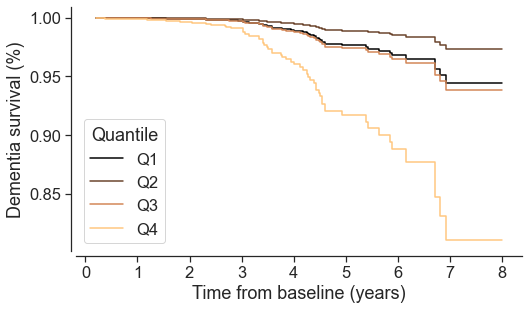

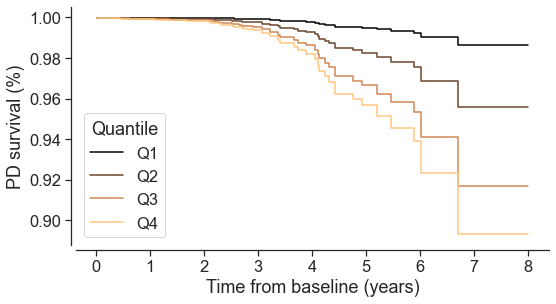

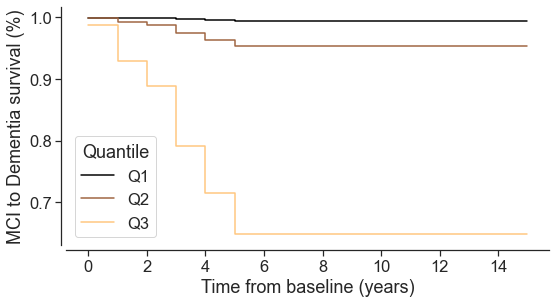

In [14]:
import seaborn as sns
sns.set_theme("notebook", font_scale=1.5, font='DejaVu Sans Mono', rc={"lines.linewidth": 1.5})
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

fig, ax2 = plt.subplots(nrows=1, figsize=(8, 4.5))

cph = MAP['ALL_DEMENTIA'][0]
input_data_survival = MAP['ALL_DEMENTIA'][1]
covariate_columns = MAP['ALL_DEMENTIA'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax2 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax2, cmap="copper")
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile')
ax2.set_ylabel("Dementia survival (%)")
ax2.set_xlabel("Time from baseline (years)")
sns.despine(ax=ax2, top=True, right=True, left=False, bottom=False, offset=5, trim=False)
fig.savefig("Figure3/survival_plots_dementia.pdf", bbox_inches="tight")
fig.savefig('Figure3/survival_plots_dementia.png', dpi=200, bbox_inches = "tight")

fig, ax1 = plt.subplots(nrows=1, figsize=(8, 4.5))
cph = MAP['PD'][0]
input_data_survival = MAP['PD'][1]
covariate_columns = MAP['PD'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax1 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax1, cmap="copper")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile')
ax1.set_ylabel("PD survival (%)")
ax1.set_xlabel("Time from baseline (years)")
fig.tight_layout()
sns.despine(ax=ax1, top=True, right=True, left=False, bottom=False, offset=5, trim=False)
fig.savefig("Figure3/survival_plots_pd.pdf", bbox_inches="tight")
fig.savefig('Figure3/survival_plots_pd.png', dpi=200, bbox_inches = "tight")


fig, ax3 = plt.subplots(nrows=1, figsize=(8, 4.5))
cph = MAP['MCI'][0]
input_data_survival = MAP['MCI'][1]
covariate_columns = MAP['MCI'][2]
v1 = np.zeros((1, len(covariate_columns)))
v2 = np.eye(len(covariate_columns))
ax3 = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax3, cmap="copper")
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles=handles, labels=[f'Q{i+1}' for i in range(1+len(covariate_columns))], title='Quantile')
ax3.set_ylabel("MCI to Dementia survival (%)")
ax3.set_xlabel("Time from baseline (years)")
fig.tight_layout()
sns.despine(ax=ax3, top=True, right=True, left=False, bottom=False, offset=5, trim=False)
fig.savefig("Figure3/survival_plots_mci.pdf", bbox_inches="tight")
fig.savefig('Figure3/survival_plots_mci.png', dpi=200, bbox_inches = "tight")


In [ ]:
# We will see later

In [50]:
from reportlab.pdfgen import canvas
from reportlab.pdfbase import pdfform
from reportlab.lib.utils import ImageReader
from PIL import Image
from reportlab.lib.colors import magenta, pink, blue, green, black, white
from reportlab.platypus import Paragraph, Frame


In [52]:

text_details = {
    'R6': ["(a) Parkinson's disease progression ", "(PPMI clinical assessment)", "Sample count = 200", "Subtype"],
    'R5': ["(b) Alzheimer's disease progression ", "(ADNI clinical assessment)", "Sample count = 241", "Subtype"],
    'R4': ["(c) Bleomycin lung disease and regeneration ", "(whole lung scRNA)", "Cell count = 2,738", "Cell type"],
    'R3': ["(d) Parkinson's and Alzheimer's disease progression", "(PPMI + ADNI brain T1 MRI)", "Sample count = 884", "Gender+Diagnosis"],
    'R2': ["(e) Critical care outcomes", "(MIMIC-III clinical care clinical assessment)", "Sample count = 3,543", "Critical care unit"],
    'R1': ["(f) COVID-19 disease severity ", "(plasma proteins PEA)", "Sample count = 383", "Disease severity"],
    'R0': ["(g) iPSC-derived neurons  ", "(proteomics)", "Cell count = 18", "Bioreactor culture type"],
}
def add_to_c(c, index, icon_index, img1, img2, img3, img4, img5, ratio=0):
    start_height = 190 * index
    # 2 - 188
    start_height += 2
    width = 195
    height = 150
    legend_height = 30
    text_height = 18
    text_list = text_details[f"R{icon_index}"]
    if icon_index == 1:
        icon = ImageReader('icons/covid19.png')
    elif icon_index == 2:
        icon = ImageReader('icons/icu.png')
    elif icon_index == 3:
        icon = ImageReader(f"icons/brain.png")
    elif icon_index == 0:
        icon = ImageReader(f"icons/ipsc.png")
    elif icon_index == 4:
        icon = ImageReader(f"icons/mouse.png")
    else:
        icon = ImageReader(f"icons/human.png")
    c.drawImage(icon, 5, start_height+height+18, width=18, height=15, preserveAspectRatio=False, showBoundary=False, mask='auto')

    c.drawImage(img2, 5, start_height, width=width, height=height, preserveAspectRatio=True, showBoundary=False, mask='auto')
    c.drawImage(img3, width+5, start_height, width=width, height=height, preserveAspectRatio=True, showBoundary=False, mask='auto')
    c.drawImage(img4, width * 2+5, start_height, width=width, height=height, preserveAspectRatio=True, showBoundary=False, mask='auto')

    c.drawImage(img1, 5, start_height + height, width=140, height=18, preserveAspectRatio=True, showBoundary=False, mask='auto')
    leg_width = int(ratio*15)
    c.drawImage(img5, 3*width - leg_width - 2, start_height +  height, width=leg_width, height=15, preserveAspectRatio=True, showBoundary=False, mask='auto')
    # c.drawImage(img5, 1.6*width, start_height +  height, width=leg_width, height=15, preserveAspectRatio=True, showBoundary=False, mask='auto')

    form = c.acroForm
    # 160 - 38
    form.textfield(name=f'fname1_{index}', value=text_list[0], tooltip='First Name', x=25, y=start_height + height+18, height=15, fontSize=9, width=4.7 * len(text_list[0]), borderColor=white, borderWidth=0, fillColor=white, textColor=black, forceBorder=False, fontName='Helvetica-Bold')
    form.textfield(name=f'fname3_{index}', value=text_list[1], tooltip='Samples Name', x=4.7 * len(text_list[0])+20, y=start_height + height+17, height=15, fontSize=8, width=4.25 * len(text_list[1]), borderWidth=0, borderColor=white, fillColor=white, textColor=black, forceBorder=False)# , fontName='Times-Bold')

    form.textfield(name=f'fname2_{index}', value=text_list[2], tooltip='Samples Name', x=160, y= start_height + height, height=15, fontSize=8, width=120, borderColor=white, borderWidth=0, fillColor=white, textColor=black, forceBorder=False)# , fontName='Times-Bold')
    form.textfield(name=f'fname4_{index}', value=text_list[3], tooltip='Samples Name', x=3*width - 4.7 * len(text_list[3]) - 30, y=start_height + height+15, height=15, fontSize=8, width=4.7 * len(text_list[3]), borderColor=white, fillColor=white, textColor=black,  borderWidth=0, forceBorder=False)# , fontName='Times-Bold')
    # form.textfield(name=f'fname4_{index}', value=text_list[3], tooltip='Samples Name', x=3*width - leg_width - 2, y=start_height + height+15, height=15, fontSize=8, width=leg_width, borderColor=white, fillColor=white, textColor=black, forceBorder=False)# , fontName='Times-Bold')
    # form.textfield(name=f'fname4_{index}', value=text_list[3], tooltip='Samples Name', x=width*2, y=start_height + height+15, height=15, fontSize=8, width=leg_width, borderColor=white, fillColor=white, textColor=black, forceBorder=False)# , fontName='Times-Bold')

    # form.textfield(name=f'fname1_{index}', value=text_list[0], tooltip='First Name', x=25, y=start_height + height + 18,
    #                height=18, fontSize=8, width=160, borderColor=white, fillColor=white, textColor=black,
    #                forceBorder=False, fontName='Helvetica-Bold')
    # form.textfield(name=f'fname3_{index}', value=text_list[1], tooltip='Samples Name', x=185,
    #                y=start_height + height + 18, height=18, fontSize=8, width=110, borderColor=white, fillColor=white,
    #                textColor=black, forceBorder=False)  # , fontName='Times-Bold')
    # form.textfield(name=f'fname2_{index}', value=text_list[2], tooltip='Samples Name', x=160, y=start_height + height,
    #                height=18, fontSize=8, width=120, borderColor=white, fillColor=white, textColor=black,
    #                forceBorder=False)  # , fontName='Times-Bold')
    # form.textfield(name=f'fname4_{index}', value=text_list[3], tooltip='Samples Name', x=width * 1.6,
    #                y=start_height + height + 15, height=15, fontSize=8, width=leg_width, borderColor=white,
    #                fillColor=white, textColor=black, forceBorder=False)  # , fontName='Times-Bold')


    c.drawBoundary(sb=1, y=190 * index + 1, x=3, w=590, h=188)


# c = canvas.Canvas('mainimage.pdf', pagesize=(595.27, 841.69))
c = canvas.Canvas('Figure3.pdf', pagesize=(595.27, 1341.69))
img1 = ImageReader(f"Figure3/effect_size_plots.png")
img2 = ImageReader(f"Figure3/survival_plots_pd.png")
img3 = ImageReader(f"Figure3/survival_plots_dementia.png")
img4 = ImageReader(f"Figure3/survival_plots_mci.png")
c.drawImage(img2, 5, 2, width=195, height=150, preserveAspectRatio=True, showBoundary=False, mask='auto')
c.drawImage(img3, 5, 2, width=195, height=300, preserveAspectRatio=True, showBoundary=False, mask='auto')
c.drawImage(img4, 5, 2, width=195, height=450, preserveAspectRatio=True, showBoundary=False, mask='auto')

# c.drawImage(img3, 5, start_height, width=width, height=height, preserveAspectRatio=True, showBoundary=False, mask='auto')
# c.drawImage(img4, 5, start_height, width=width, height=height, preserveAspectRatio=True, showBoundary=False, mask='auto')
# add_to_c(c, index, index, img1, img2, img3, img4, img5, ratio = x.size[0]/float(x.size[1]))
c.save()




In [53]:
from PyPDF2 import PdfReader

reader = PdfReader(f"Figure3/survival_plots_pd.pdf")

page = reader.pages[0]
count = 0

for image_file_object in page.images:
    with open(str(count) + image_file_object.name, "wb") as fp:
        fp.write(image_file_object.data)
        count += 1

In [57]:
page

{'/Annots': [],
 '/Contents': {'/Filter': '/FlateDecode'},
 '/MediaBox': [0, 0, 555.629375, 303.504375],
 '/Parent': {'/Count': 1,
  '/Kids': [IndirectObject(11, 0, 6111159008)],
  '/Type': '/Pages'},
 '/Resources': {'/ExtGState': {'/A1': {'/CA': 0,
    '/Type': '/ExtGState',
    '/ca': 1},
   '/A2': {'/CA': 1, '/Type': '/ExtGState', '/ca': 1},
   '/A3': {'/CA': 0.8, '/Type': '/ExtGState', '/ca': 0.8}},
  '/Font': {'/F1': {'/BaseFont': '/GOFYPY+ArialMT',
    '/CharProcs': {'/D': {'/Filter': '/FlateDecode'},
     '/P': {'/Filter': '/FlateDecode'},
     '/Q': {'/Filter': '/FlateDecode'},
     '/T': {'/Filter': '/FlateDecode'},
     '/a': {'/Filter': '/FlateDecode'},
     '/b': {'/Filter': '/FlateDecode'},
     '/e': {'/Filter': '/FlateDecode'},
     '/eight': {'/Filter': '/FlateDecode'},
     '/f': {'/Filter': '/FlateDecode'},
     '/five': {'/Filter': '/FlateDecode'},
     '/four': {'/Filter': '/FlateDecode'},
     '/i': {'/Filter': '/FlateDecode'},
     '/l': {'/Filter': '/FlateDecode'

In [51]:
x = Image.open(f"Figure3/survival_plots_mci.png")
print (x.size[0]/float(x.size[1]))

1.8315539739027284


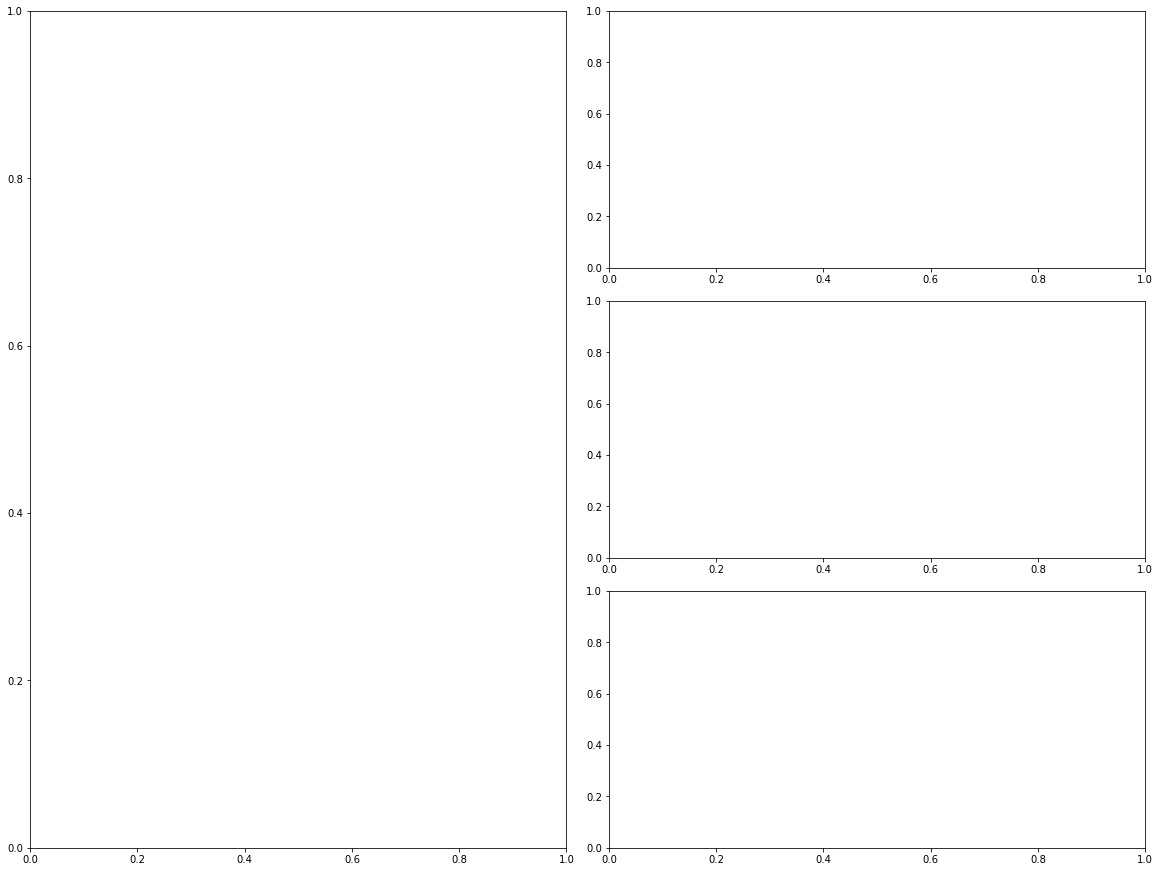

In [15]:
fig, axd = plt.subplot_mosaic([['left', 'upper right'], ['left', 'middle right'], ['left', 'lower right']], figsize=(16, 12), layout="constrained")

In [16]:
axd

{'left': <AxesSubplot:label='left'>,
 'upper right': <AxesSubplot:label='upper right'>,
 'middle right': <AxesSubplot:label='middle right'>,
 'lower right': <AxesSubplot:label='lower right'>}

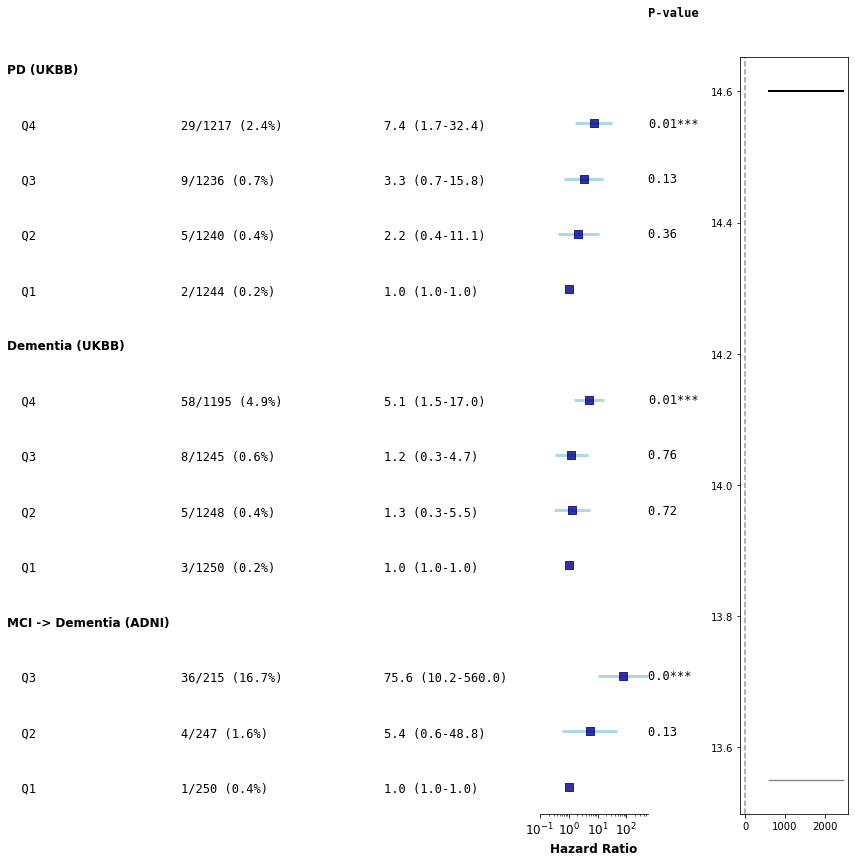

In [25]:
import myforestplot.forestplot.plot as fp
# fig, axd = plt.subplot_mosaic([['upper left', 'right'],
#                                ['lower left', 'right']],
#                             figsize=(16, 12), layout="constrained")

# fig, axd = plt.subplot_mosaic([['left', 'upper right'], ['left', 'middle right'], ['left', 'lower right']], figsize=(16, 12))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 12))
ax = fp.forestplot(
              ax=ax1, 
              dataframe=surv_dataframe.sort_values(by='label', ascending=False),  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              capitalize=None,  # Capitalize labels
              pval="pval",  # column containing p-values to be formatted
              annote=["diagnosis_par", "man_est_ci"],  # columns to report on left of plot
              annoteheaders=["Diagnosis/participants (%)", "Hazard Ratio (95% CI)"],  # ^corresponding headers
              rightannote=["formatted_pval"],  # columns to report on right of plot 
              right_annoteheaders=["P-value"],  # ^corresponding headers
              groupvar="group",  # column containing group labels
              group_order=[f"PD (UKBB)", f"Dementia (UKBB)", f"MCI -> Dementia (ADNI)"],                   
              xlabel="Hazard Ratio",  # x-label title
              xticks=[0.1, 1, 10, 100],  # x-ticks to be printed
              sort=False,  # sort estimates in ascending order
              table=True,  # Format as a table
              logscale=True,
              figsize=(4, 12),
              # color_alt_rows=True,
              # Additional kwargs for customizations
              **{"marker": "s",  # set maker symbol as diamond
                 "markersize": 50,  # adjust marker size
                 "markercolor": "darkblue", # "darkgreen",
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xtick_size": 12,  # adjust x-ticker fontsize
                 "capsize": 3,
                 "linecolor": "lightblue",
                 "lw": 3,
                 "fontfamily": 'DejaVu Sans Mono',
                }  
              )

# "Lucida Sans Typewriter",
# "DejaVu Sans Mono",
# "Courier New",
# "Lucida Console",
plt.axvline(x = 1, color = 'k', linestyle = '--', alpha=0.4)
ax.get_yticklabels()[-1].set_text(ax.get_yticklabels()[-1].get_text().replace("Variable", "Quantile"))
setting_labs = []
for i in ax.get_yticklabels():
    setting_labs.append(i)

_ = ax.set_yticklabels(setting_labs)
fig.tight_layout()
fig.savefig("Figure3/effect_size_plots.pdf", bbox_inches="tight")
fig.savefig('Figure3/effect_size_plots.png', dpi=100, bbox_inches = "tight")

# EXTRADS

In [324]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def save_image(figs, filename):
    
    # PdfPages is a wrapper around pdf 
    # file so there is no clash and create
    # files with no error.
    p = PdfPages(filename)
      
    # get_fignums Return list of existing 
    # figure numbers
    # fig_nums = plt.get_fignums()  
    # figs = [plt.figure(n) for n in fig_nums]
      
    # iterating over the numbers in list
    for fig in figs: 
        
        # and saving the files
        fig.savefig(p, format='pdf', bbox_inches = "tight") 
      
    # close the object
    p.close()  
  
# name your Pdf file
filename = "multi_plot_image.pdf"  
figs = [ax.figure, ax.figure]
# call the function
save_image(figs, filename)
785 / 1005
from PIL import Image

im = Image.open('Figure3/effect_size_plots.png')
im.size # (width,height) tuple

In [325]:
ax.get_yticklabels()[-1]

Text(0, 10, 'Quantile      Diagnosis/participants (%)  Hazard Ratio (95% CI)')

<AxesSubplot:xlabel='Pearson correlation coefficient'>

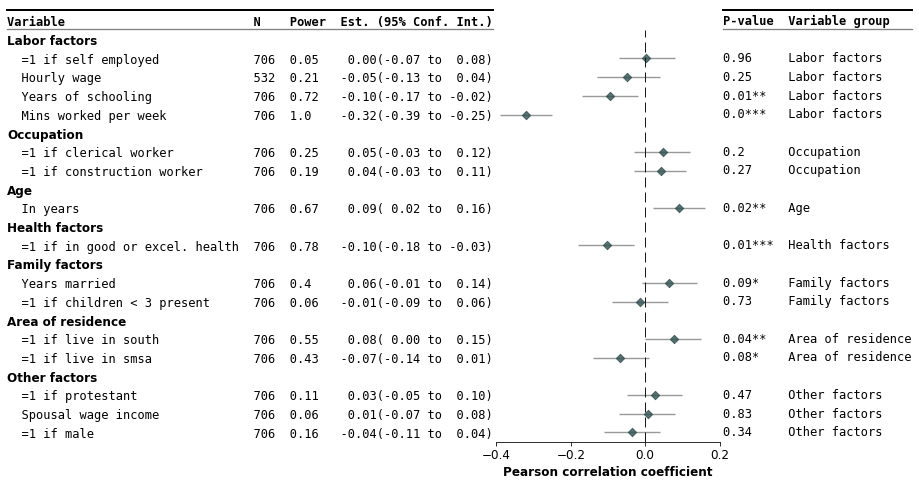

In [255]:
fp.forestplot(df,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              capitalize="capitalize",  # Capitalize labels
              pval="p-val",  # column containing p-values to be formatted
              annote=["n", "power", "est_ci"],  # columns to report on left of plot
              annoteheaders=["N", "Power", "Est. (95% Conf. Int.)"],  # ^corresponding headers
              rightannote=["formatted_pval", "group"],  # columns to report on right of plot 
              right_annoteheaders=["P-value", "Variable group"],  # ^corresponding headers
              groupvar="group",  # column containing group labels
              group_order=["labor factors", "occupation", "age", "health factors", 
                           "family factors", "area of residence", "other factors"],                   
              xlabel="Pearson correlation coefficient",  # x-label title
              xticks=[-.4,-.2,0, .2],  # x-ticks to be printed
              sort=True,  # sort estimates in ascending order
              table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": ".1",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                }  
              )

<AxesSubplot:xlabel='Pearson correlation coefficient'>

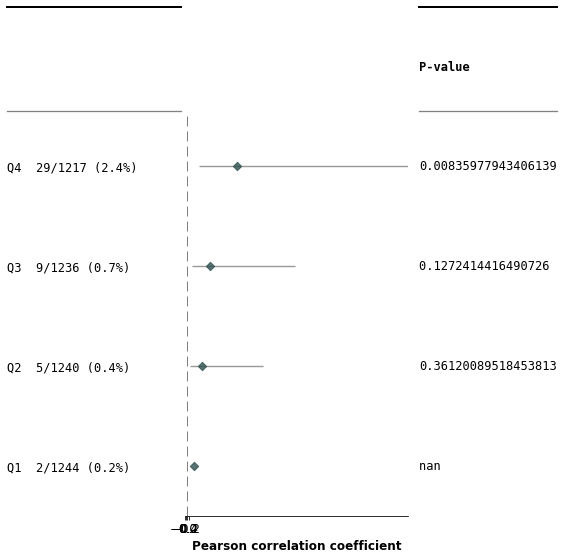

In [163]:
fp.forestplot(surv_dataframe,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              capitalize="capitalize",  # Capitalize labels
              pval="pval",  # column containing p-values to be formatted
              annote=["diagnosis_par"],  # columns to report on left of plot
              annoteheaders=["diagnosis_par"],  # ^corresponding headers
              rightannote=["pval"],  # columns to report on right of plot 
              right_annoteheaders=["P-value"],  # ^corresponding headers              
              xlabel="Pearson correlation coefficient",  # x-label title
              xticks=[-.4,-.2,0, .2],  # x-ticks to be printed
              sort=True,  # sort estimates in ascending order
              table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                }  
              )

In [156]:
df

,n,r,CI95%,p-val,BF10,power,var,hl,ll,moerror,group,label
0,706,0.090373,[0.02 0.16],1.630887e-02,8.390000e-01,0.67,age,0.16,0.02,0.069627,age,in years
1,706,0.048081,[-0.03 0.12],2.019484e-01,1.060000e-01,0.25,clerical,0.12,-0.03,0.071919,occupation,=1 if clerical worker
2,706,0.041229,[-0.03 0.11],2.739475e-01,8.600000e-02,0.19,construc,0.11,-0.03,0.068771,occupation,=1 if construction worker
3,706,-0.095004,[-0.17 -0.02],1.155151e-02,1.137000e+00,0.72,educ,-0.02,-0.17,0.075004,labor factors,years of schooling
4,706,-0.102825,[-0.18 -0.03],6.246660e-03,1.967000e+00,0.78,gdhlth,-0.03,-0.18,0.072825,health factors,=1 if in good or excel. health
5,706,-0.066997,[-0.14 0.01],7.524015e-02,2.290000e-01,0.43,smsa,0.01,-0.14,0.076997,area of residence,=1 if live in smsa
6,706,-0.035909,[-0.11 0.04],3.407214e-01,7.400000e-02,0.16,male,0.04,-0.11,0.075909,other factors,=1 if male
7,706,0.027147,[-0.05 0.1 ],4.714176e-01,6.100000e-02,0.11,prot,0.10,-0.05,0.072853,other factors,=1 if Protestant
8,706,0.001782,[-0.07 0.08],9.623058e-01,4.700000e-02,0.05,selfe,0.08,-0.07,0.078218,labor factors,=1 if self employed
9,706,0.078600,[0. 0.15],3.679946e-02,4.150000e-01,0.55,south,0.15,0.00,0.071400,area of residence,=1 if live in south


<AxesSubplot:xlabel='Pearson correlation coefficient'>

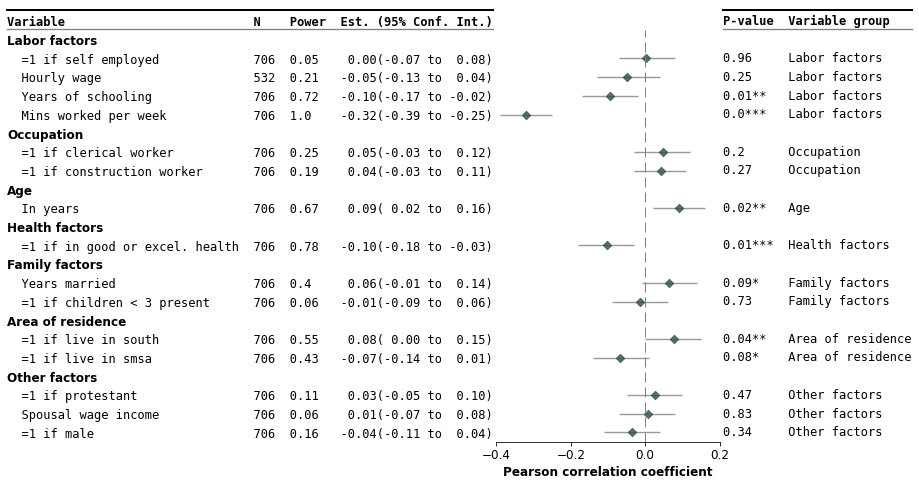

In [155]:
df = fp.load_data("sleep")
fp.forestplot(df,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # lower & higher limits of conf. int.
              varlabel="label",  # column containing the varlabels to be printed on far left
              capitalize="capitalize",  # Capitalize labels
              pval="p-val",  # column containing p-values to be formatted
              annote=["n", "power", "est_ci"],  # columns to report on left of plot
              annoteheaders=["N", "Power", "Est. (95% Conf. Int.)"],  # ^corresponding headers
              rightannote=["formatted_pval", "group"],  # columns to report on right of plot 
              right_annoteheaders=["P-value", "Variable group"],  # ^corresponding headers
              groupvar="group",  # column containing group labels
              group_order=["labor factors", "occupation", "age", "health factors", 
                           "family factors", "area of residence", "other factors"],                   
              xlabel="Pearson correlation coefficient",  # x-label title
              xticks=[-.4,-.2,0, .2],  # x-ticks to be printed
              sort=True,  # sort estimates in ascending order
              table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                }  
              )

In [10]:
import forestplot as fp

df = fp.load_data("sleep")  # companion example data
df.head(3)

,n,r,CI95%,p-val,BF10,power,var,hl,ll,moerror,group,label
0,706,0.090373,[0.02 0.16],0.016309,0.839,0.67,age,0.16,0.02,0.069627,age,in years
1,706,0.048081,[-0.03 0.12],0.201948,0.106,0.25,clerical,0.12,-0.03,0.071919,occupation,=1 if clerical worker
2,706,0.041229,[-0.03 0.11],0.273948,0.086,0.19,construc,0.11,-0.03,0.068771,occupation,=1 if construction worker


In [11]:
df

,n,r,CI95%,p-val,BF10,power,var,hl,ll,moerror,group,label
0,706,0.090373,[0.02 0.16],1.630887e-02,8.390000e-01,0.67,age,0.16,0.02,0.069627,age,in years
1,706,0.048081,[-0.03 0.12],2.019484e-01,1.060000e-01,0.25,clerical,0.12,-0.03,0.071919,occupation,=1 if clerical worker
2,706,0.041229,[-0.03 0.11],2.739475e-01,8.600000e-02,0.19,construc,0.11,-0.03,0.068771,occupation,=1 if construction worker
3,706,-0.095004,[-0.17 -0.02],1.155151e-02,1.137000e+00,0.72,educ,-0.02,-0.17,0.075004,labor factors,years of schooling
4,706,-0.102825,[-0.18 -0.03],6.246660e-03,1.967000e+00,0.78,gdhlth,-0.03,-0.18,0.072825,health factors,=1 if in good or excel. health
5,706,-0.066997,[-0.14 0.01],7.524015e-02,2.290000e-01,0.43,smsa,0.01,-0.14,0.076997,area of residence,=1 if live in smsa
6,706,-0.035909,[-0.11 0.04],3.407214e-01,7.400000e-02,0.16,male,0.04,-0.11,0.075909,other factors,=1 if male
7,706,0.027147,[-0.05 0.1 ],4.714176e-01,6.100000e-02,0.11,prot,0.10,-0.05,0.072853,other factors,=1 if Protestant
8,706,0.001782,[-0.07 0.08],9.623058e-01,4.700000e-02,0.05,selfe,0.08,-0.07,0.078218,labor factors,=1 if self employed
9,706,0.078600,[0. 0.15],3.679946e-02,4.150000e-01,0.55,south,0.15,0.00,0.071400,area of residence,=1 if live in south


<AxesSubplot:xlabel='Pearson correlation', ylabel='Confidence interval'>

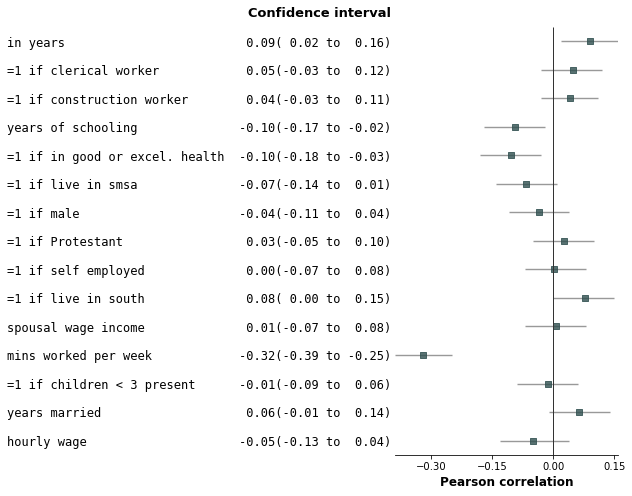

In [5]:
fp.forestplot(df,  # the dataframe with results data
              estimate="r",  # col containing estimated effect size 
              ll="ll", hl="hl",  # columns containing conf. int. lower and higher limits
              varlabel="label",  # column containing variable label
              ylabel="Confidence interval",  # y-label title
              xlabel="Pearson correlation",  # x-label title
              )

In [ ]:
import os
from pathlib import Path
import pandas as pd
from lifelines import CoxPHFitter
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.datasets import load_waltons
from contextlib import redirect_stdout

from collections import defaultdict

evaluation_generated_dir = Path("/Users/projects_data/project_MLPhenotypesMRIGWAS/evaluation_generated_data/23_03") / "survival_analysis_cluster"
organized_generated_dir = Path("/Users/projects_data/project_MLPhenotypesMRIGWAS/organized_data/23_03")
os.makedirs(evaluation_generated_dir, exist_ok=True)

data_all = pd.read_parquet(organized_generated_dir / 'combinedData.parquet.gzip')
data_all['id_invicrot1_vol_temporal_rdktlobes'] = 1 - data_all['id_invicrot1_vol_temporal_rdktlobes']
data_all['id_invicrot1_vol_gmtissues'] = 1 - data_all['id_invicrot1_vol_gmtissues']
data_all['id_invicrot1_vol_left_entorhinaldktcortex'] = 1 - data_all['id_invicrot1_vol_left_entorhinaldktcortex']

subject_max = data_all.set_index('eid')[['Age_i0', 'Age_i1', 'Age_i2', 'Age_i3']].agg(max, axis=1) # - data.set_index('eid')[['Age_i0', 'Age_i1', 'Age_i2', 'Age_i3']].agg(min, axis=1)
subject_max = subject_max.reset_index().groupby('eid').agg('max')[0]
study_time = dict(zip(list(subject_max.index), list(subject_max.values)))

data = data_all[data_all['ukbb_id_nih'].str.contains('20252_2_0')].copy().set_index('eid')

disease = "PD"
formula = f"Age_at_image_taken + townsend + Sex + PD_prs + norm_PD_imaging_score"
variable_of_interest = "norm_PD_imaging_score"
censoring_time = 3650

list_disease = ['PD', 'ALL_DEMENTIA', 'PARKINSONISM', 'AD', "MS", "STROKE", "OtMOVEMENT", "DYSTONIA"]
list_disease = ['PD']
list_formula = [
    # f"Age_at_image_taken + townsend + Sex + AD_prs + var:id_invicrot1_vol_temporal_rdktlobes",
    # f"Age_at_image_taken + townsend + Sex + AD_prs + var:id_invicrot1_vol_gmtissues",
    # f"Age_at_image_taken + townsend + Sex + AD_prs + var:id_invicrot1_vol_left_entorhinaldktcortex",
    # f"Age_at_image_taken + townsend + Sex + AD_prs + PD_prs + var:norm_AD_imaging_score + var:norm_PD_imaging_score"
    f"Age_at_image_taken + townsend + Sex + PD_prs + var:norm_PD_imaging_score",
    # f"Age_at_image_taken + townsend + Sex + AD_prs + var:norm_AD_imaging_score",
]


for temp_formula in list_formula:
    for disease in list_disease:
        list_variable_of_interest = [var.split(':')[1] for var in temp_formula.split(' + ') if 'var' in var]
        formula = temp_formula.replace('var:', '')
        if True:
            # variable_of_interest = formula.split(' + ')[-1]
            fname = f"{disease}&{formula.replace(' + ', '@')}"
            os.makedirs(evaluation_generated_dir / fname, exist_ok=True)
            duration_col = f"daysFromDiagnosis_image_taken_{disease}"
            data[duration_col] = data[f'Date_of_{disease}'] - data['Date_of_attending_assessment_centre']
            data['Age_at_image_taken'] = data['Age.when.attended.assessment.centre_nih'].values

            temp_input_data = data.copy()
            event_subjects = temp_input_data[temp_input_data[duration_col] > 0].index
            event_subjects_data = temp_input_data.loc[event_subjects].copy()
            event_subjects_data[f"Status_{duration_col}"] = 1

            right_censored_subjects = temp_input_data[temp_input_data[duration_col].isnull()].index
            right_censored_subjects_data = temp_input_data.loc[right_censored_subjects].copy()
            right_censored_subjects_data[duration_col] = 365 * (right_censored_subjects_data.index.map(lambda x: study_time[x]) - right_censored_subjects_data['Age_at_image_taken'])
            right_censored_subjects_data = right_censored_subjects_data[right_censored_subjects_data[duration_col] > 0]
            right_censored_subjects_data[f"Status_{duration_col}"] = 0

            input_data = pd.concat([event_subjects_data, right_censored_subjects_data], axis=0)

            input_data_columns = formula.split(' + ') + [ duration_col, f"Status_{duration_col}" ]
            input_data_survival = input_data[input_data_columns].copy().dropna(subset=formula.split(' + '))

            input_data_survival_class1 = input_data_survival[input_data_survival[f"Status_{duration_col}"] == 1].copy()
            input_data_survival_class0 = input_data_survival[input_data_survival[f"Status_{duration_col}"] == 0].sample(n=len(input_data_survival_class1)).copy()
            input_data_survival_balanced = pd.concat([input_data_survival_class0, input_data_survival_class1], axis=0)
            covariate_columns = []
            for variable_of_interest in list_variable_of_interest:
                formula = formula.replace(variable_of_interest, "")
                v = pd.qcut(input_data_survival[variable_of_interest], 4)
                input_data_survival[f"quantiles_{variable_of_interest}"] = v.cat.codes.map(lambda x: f'Q{x}')
                addition_columns = pd.get_dummies(input_data_survival[f"quantiles_{variable_of_interest}"])
                addition_columns.columns = [f"{variable_of_interest}_{j}" for j in addition_columns.columns]
                formula += ' + '.join(list(addition_columns.columns)[1:])
                input_data_survival = pd.concat([input_data_survival, addition_columns], axis=1)
                covariate_columns.extend(list(addition_columns.columns)[1:])

            cph = CoxPHFitter()
            cph.fit(input_data_survival, duration_col=duration_col, event_col=f"Status_{duration_col}", formula=formula)
            fig, ax = plt.subplots()
            v1 = np.zeros((1, len(covariate_columns)))
            v2 = np.eye(len(covariate_columns))
            ax = cph.plot_partial_effects_on_outcome(covariates=covariate_columns, plot_baseline=False, values=np.concatenate([v1, v2]), ax=ax)
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles, labels=[f'Q{i}' for i in range(1+len(covariate_columns))])
            fig.savefig(evaluation_generated_dir / fname / "Survival_plot_Quantiles.png")
            fig.savefig(evaluation_generated_dir / fname / "Survival_plot_Quantiles.pdf")

            fig, ax = plt.subplots()
            cph.plot(columns=sorted(covariate_columns)[::-1], hazard_ratios=True, ax=ax)
            labels = [item.get_text().split('_')[-1] for item in ax.get_yticklabels()]
            ax.set_yticklabels(labels)
            fig.savefig(evaluation_generated_dir / fname / "Effect_size_Quantiles.png")
            fig.savefig(evaluation_generated_dir / fname / "Effect_size_Quantiles.pdf")

            with open(evaluation_generated_dir / fname / 'Print_Summary.out', 'w') as f:
                with redirect_stdout(f):
                    cph.print_summary()
            cph.summary.reset_index().to_csv(evaluation_generated_dir / fname / "Summary.csv", index=False)

        for variable_of_interest in list_variable_of_interest:
            details_about_model = {}
            details_about_model['duration_col'] = duration_col
            details_about_model['event_col'] = f"Status_{duration_col}"
            details_about_model['formula'] = formula
            details_about_model['variable_of_interest'] = variable_of_interest
            details_about_model['concordance_index_'] = cph.concordance_index_
            details_about_model['log_likelihood_ratio_test_p_value'] = cph.log_likelihood_ratio_test().p_value
            details_about_model['log_likelihood_ratio_test_test_statistic'] = cph.log_likelihood_ratio_test().test_statistic
            details_about_model['log_likelihood_'] = cph.log_likelihood_

            for vari in cph.summary.index:
                if not variable_of_interest in vari:
                    continue
                for ind in cph.summary.loc[vari].index:
                    if ind == 'p':
                            details_about_model['-lop10(p)'] = -round(np.log10(cph.summary.loc[vari][ind]), 2)
                    details_about_model[f"{vari}_{ind}"] = cph.summary.loc[vari][ind]

            for key, val in details_about_model.items():
                details_about_model[key] = [val,]

            if os.path.exists(evaluation_generated_dir / "results_summary.csv"):
                prev_results = pd.read_csv(evaluation_generated_dir / "results_summary.csv")
                prev_results = pd.concat([prev_results, pd.DataFrame(details_about_model)], axis=0)
                prev_results = prev_results.drop_duplicates(subset=['duration_col', 'event_col', 'formula', 'variable_of_interest'])
                prev_results.to_csv(evaluation_generated_dir / "results_summary.csv", index=False)
            else:
                pd.DataFrame(details_about_model).to_csv(evaluation_generated_dir / "results_summary.csv", index=False)

            fig, ax = plt.subplots()
            cph.plot(hazard_ratios=True, ax=ax)
            plt.tight_layout()
            fig.savefig(evaluation_generated_dir / fname / f"EffectSize_{variable_of_interest}.png")
            fig.savefig(evaluation_generated_dir / fname / f"EffectSize_{variable_of_interest}.pdf")

            fig, ax = plt.subplots()
            list_of_values = sorted(v.map(lambda x: x.right).astype(float).unique())
            cph.plot_partial_effects_on_outcome(covariates=variable_of_interest, values=list_of_values, ax=ax) # , cmap='coolwarm'
            plt.tight_layout()
            fig.savefig(evaluation_generated_dir / fname / f"PartialEffects_Quantiles_{variable_of_interest}.png")
            fig.savefig(evaluation_generated_dir / fname / f"PartialEffects_Quantiles_{variable_of_interest}.pdf")

            fig, ax = plt.subplots(figsize=(8, 8))
            kmfs = []
            for ijk in sorted(input_data_survival[f"quantiles_{variable_of_interest}"].unique()):
                ix1 = input_data_survival[input_data_survival[f'quantiles_{variable_of_interest}'] == ijk]
                kmf1 = KaplanMeierFitter()
                ax = kmf1.fit(ix1[f"{duration_col}"], ix1[f"Status_{duration_col}"], label=ijk).plot_survival_function(ax=ax)
                kmfs.append(kmf1)
            # ix2 = input_data_survival[input_data_survival[f'quantiles_{variable_of_interest}'] == 'Q1']
            # ix3 = input_data_survival[input_data_survival[f'quantiles_{variable_of_interest}'] == 'Q2']
            # ix4 = input_data_survival[input_data_survival[f'quantiles_{variable_of_interest}'] == 'Q3']
            # kmf2 = KaplanMeierFitter()
            # ax = kmf2.fit(ix2[f"{duration_col}"], ix2[f"Status_{duration_col}"], label='Q1').plot_survival_function(ax=ax)
            # kmf3 = KaplanMeierFitter()
            # ax = kmf3.fit(ix3[f"{duration_col}"], ix3[f"Status_{duration_col}"], label='Q2').plot_survival_function(ax=ax)
            # kmf4 = KaplanMeierFitter()
            # ax = kmf4.fit(ix4[f"{duration_col}"], ix4[f"Status_{duration_col}"], label='Q3').plot_survival_function(ax=ax)
            add_at_risk_counts(*kmfs, ax=ax)
            plt.tight_layout()
            fig.savefig(evaluation_generated_dir / fname / f"KaplanMeier_Quantiles_{variable_of_interest}.png")
            fig.savefig(evaluation_generated_dir / fname / f"KaplanMeier_Quantiles_{variable_of_interest}.pdf")


        # import sys; sys.exit()
        # selected_columns = ["Date_of_attending_assessment_centre", "townsend", "Sex",
        #                    'Age.when.attended.assessment.centre_nih', # 'Age.when.attended.assessment.centre_invicro',
        #                    "Date.of.attending.assessment.centre_invicro", 'Date.of.attending.assessment.centre_nih', 'eid',
        #                    'birthMonthYear', 'Age_from_dates']
        # gap of 1 year due to only month available
        # data['Age_from_dates'] = data['Date_of_attending_assessment_centre'] - data['birthMonthYear']
        # data['Age_from_dates'] = data['Age_from_dates'].map(lambda x: x/365)
        # a = data['Age_from_dates'] == data['Age.when.attended.assessment.centre_nih'].map(int)
        # data.loc[a[~a].index][selected_columns]
        # data['Age_from_dates'] = s // 365
